# Comparing Tautomer Generation Algorithms

[Tautomers](https://en.wikipedia.org/wiki/Tautomer) are chemical structures that readily interconvert under given conditions. For example, an amino acid has a neutral form, and a zwitterionic form with separated positive and negative charges. Cheminformatics packages have algorithms to enumerate tautomers based on rules. Which algorithms produce the most tautomers? And how successful is InChI at representing with a single identifier all tautomers of a given structure?

![Tautomeric forms of an amino acid: neutral (1) and zwitterionic (2)](../images/Amino_acid_zwitterions.svg)

[Image](https://commons.wikimedia.org/wiki/File:Amino_acid_zwitterions.svg) credit: [TimVickers](https://en.wikipedia.org/wiki/User:TimVickers) vector version by [YassineMrabet](https://commons.wikimedia.org/wiki/User:YassineMrabet)


The tautomer generation algorithms discussed below are based on rules from Markus Sitzmann, Wolf-Dietrich Ihlenfeldt, and Marc C. Nicklaus, “Tautomerism in Large Databases”, _JCAMD_ 24:521 (2010) https://doi.org/10.1007/s10822-010-9346-4.

RDKit has two tautomer generation algorithms, [GetV1TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.GetV1TautomerEnumerator) and the [new algorithm, TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.TautomerEnumerator). The [2022.03 release notes](https://www.rdkit.org/docs/BackwardsIncompatibleChanges.html#tautomer-enumeration-improvements) state:
> The rules for tautomer enumeration in MolStandardize have been updated to more closely match the rules in the original publication [cited above]. These changes primarily consist of making the rules more specific; the consequence is that less tautomers will be generated with this version.

but maintainer Greg Landrum [wrote](https://github.com/rdkit/rdkit/discussions/6997#discussioncomment-7893160)
> [the new TautomerEnumerator returning fewer examples than the previous rules V1 is] not something I've noticed. The code change adds a missed case to the enumeration rule set, so at first glance you'd expect it to always produce more tautomers, but I suppose that could still result in a smaller number of tautomers in the end because of how the transformations interact with each other.

 National Institutes of Health (NIH) [CADD Group Chemoinformatics Tools and User Services (CACTUS)](https://cactus.nci.nih.gov/) also has algorithms that can be run on a [Tautomerizer web page](https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl) or with the package [CACTVS](https://www.cactvs.com/academic/) from Xemistry GmbH. NIH's Marc Nicklaus notes that CACTVS has "many additional transforms vs. the ones we used in 2010 [for the paper cited above]. This now includes numerous ring-chain and valence tautomerism rules, for a total of...120 rules" (private communications). We compare these two NIH algorithms to the new RDKit algorithm. Because I couldn't install CACTVS on my computer due to CPU compatibility, I used the web site which has 86 rules, and Marc kindly ran CACTVS for a few structures using "exhaustive multi-step enumeration iteratively with all rules, until no more new tautomer is found (with a limit of 1,000 attempts)".

So one purpose of this blog post is to empirically answer the question of which algorithms produce more tautomers, and particularly whether the new RDKit algorithm produces more or fewer tautomers than the V1 algorithm.

The second purpose is to check how well [InChI](https://en.wikipedia.org/wiki/International_Chemical_Identifier) (International Chemical Identifier) accomplishes its goal of being ["tautomer-invariant"](https://cactus.nci.nih.gov/presentations/NIHInChI_2021-03/Day_1_Nicklaus_Tautomerism_2021-03-21A.pdf), meaning tautomers of a structure should be assigned the same InChI, so ideally only one InChI should be able to represent all tautomers of a given structure. However, "[It was recognized early on that important types of tautomerism are missing](https://cactus.nci.nih.gov/presentations/NIHInChI_2021-03/Day_1_Nicklaus_Tautomerism_2021-03-21A.pdf)," so we should not expect InChI to be completely successful at present.

To empirically compare these questions, we need a set of molecules which have tautomers: Many molecules will not have any tautomers. Nicklaus and team also created [Tautomer Structures Extracted from Experimental Literature](https://cactus.nci.nih.gov/download/tautomer/), with 
> 5,977 structures extracted from experimental literature representing 2,819 cases of tautomeric tuples (mostly tautomer pairs but also a few triples and higher-order tuples). Note that the number of structurally different tuples is only 1,776 (comprising 3,884 different structures) since some tuples are differentiated from each other only by experimental conditions such as solvent, spectroscopy method, etc.

We use release 3 in Excel format, specifically [Tautomer_database_release_3a.xlsx](https://cactus.nci.nih.gov/download/tautomer/Tautomer_database_release_3a.xlsx).

## Code foundation

In [1]:
import sys
print(sys.version)

3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)]


In [2]:
# !pip install rdkit polars>=0.20.7 seaborn matplotlib

In [3]:
from typing import Iterable, Callable
import warnings
import statistics
from statistics import StatisticsError

In [4]:
from rdkit.Chem import AllChem as Chem
from rdkit import RDLogger
from rdkit.Chem import Draw, rdFMCS
from rdkit.Chem import Mol
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
import polars.selectors as cs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [5]:
# Suppress RDKit warnings so it doesn't warn about SMILES that produce molecules which violate a rule,
# which would produce many warnings as we create thousands of molecules
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [6]:
# Ignore all FutureWarnings--there are several from internal code of imported packages
warnings.simplefilter(action='ignore', category=FutureWarning)

These functions convert SMILES to RDKit molecules to canonical SMILES.

In [7]:
def mol_from_sml(sml: str) -> Mol|None:
    """Create an RDKit molecule from a SMILES string.
    RDKit cannot create molecules from some SMILES strings if it tries to sanitize them,
    but sometimes can if it does not sanitize them.
    It is preferable to sanitize molecules if possible because that does things such as
    delocalize aromatic bonds (instead of alternating single and double bonds),
    which makes different structures (single-double vs. double-single bond sequence) give the same molecule.

    :param sml: SMILES string
    :returns: RDKit molecule if SMILES is valid; None if invalid
    """
    # Try sanitizing molecule first
    mol = Chem.MolFromSmiles(sml, sanitize=True)
    if mol is not None:
        return mol
    # If sanitization fails, turn it off and try creating molecule again
    mol = Chem.MolFromSmiles(sml, sanitize=False)
    return mol

In [8]:
def canon_sml_or_none(mol: Mol|None) -> str|None:
    """Return the canonical SMILES for an RDKit molecule if it exists; otherwise, None.

    :param mol: RDKit molecule or None
    :returns: Canonical SMILES string if RDKit molecule supplied; None if None supplied
    """
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [9]:
def canonicalize(sml:str) -> str|None:
    """
    :param sml: SMILES string
    :returns: Canonical SMILES string if RDKit molecule could be created; None if input SMILES invalid
    """
    mol = mol_from_sml(sml)
    return canon_sml_or_none(mol)

## Preparing and inspecting the data from the tautomer database

In preparation for reading in the data, we specify the file and sheet names from the [Tautomer Structures Extracted from Experimental Literature](https://cactus.nci.nih.gov/download/tautomer/).

In [10]:
# Tautomer database from https://cactus.nci.nih.gov/download/tautomer/
file_name = "../data/Tautomer_database_release_3a.xlsx"

# If you want to use only the first row for quicker debugging, use this file instead
# file_name = "../data/Tautomer_database_release_3a_first_row.xlsx"

# The name of the sheet to process
sheet_name = "Tautomer_database"

We start by reading the data from the sheet in the Excel file of the tautomer database using [`polars.read_excel`](https://docs.pola.rs/py-polars/html/reference/api/polars.read_excel.html). We have Polars consider all the data using `"infer_schema_length":10000` (there are <3,000 rows in the sheet) before deciding on data types for columns, to ensure all cells in a column fit its data type.

In [11]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_options={"infer_schema_length":10000},
    )
df.head()

Ref,Size,Solvent,Solvent_Proportion,Solvent_Mixture,Temperature,pH,Experimental_Method,Entry_ID1,Type_1,ID_Hash_1,FICTS_1,HASHISY_1,FICuS_1,TAUTOHASH_1,uuuuu_1,Std_InChIKey_1,Std_InChI_1,SMILES_1,Mol_Formula_1,Mol_Weight_1,IUPAC_Name_1,Quantitative_ratio_1,Qualitative_prevalence_1,Prevalence_Category_1,Filename_1,Publication_DOI_1,Publication_ID_1,Authors_1,Affiliation_1,Title_1,Section_1,Page_Number(s)_1,Notes_1,Cmpd_Number_1,Entry_ID2,Type_2,…,Publication_DOI_4,Publication_ID_4,Authors_4,Affiliation_4,Title_4,Section_4,Page_Number(s)_4,Notes_4,Cmpd_Number_4,Entry_ID5,Type_5,Transf_1_5,ID_Hash_5,FICTS_5,HASHISY_5,FICuS_5,TAUTOHASH_5,uuuuu_5,Std_InChIKey_5,Std_InChI_5,SMILES_5,Mol_Formula_5,Mol_Weight_5,IUPAC_Name_5,Quantitative_ratio_5,Qualitative_Prevalence_5,Prevalence_Category_5,Filename_5,Publication_DOI_5,Publication_ID_5,Authors_5,Affiliation_5,Title_5,Section_5,Page_Number(s)_5,Notes_5,Cmpd_Number_5
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str
1,2,"""Gas phase""","""nul""","""no""","""377.15-417.15""","""nul""","""1H NMR spectra…","""Prog. NMR. Spe…","""Diketo""","""8da8a44a54e4cd…","""748BBAA5E5F382…","""748BBAA5E5F382…","""748BBAA5E5F382…","""748BBAA5E5F382…","""748BBAA5E5F382…","""InChIKey=YRKCR…","""InChI=1S/C5H8O…","""O=C(C)CC(C)=O""","""C5H8O2""",100.117,"""pentane-2,4-di…","""nul""","""Observed""",1,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 1""","""171""","""nul""","""1c""","""Prog. NMR. Spe…","""Keto-enol""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,2,"""Gas phase""","""nul""","""no""","""nul""","""nul""","""nul""","""Prog. NMR. Spe…","""NH""","""ef8866bd4d9949…","""AF721AB4BAA47F…","""AF721AB4BAA47F…","""AF721AB4BAA47F…","""AF721AB4BAA47F…","""E0755E1A90D93F…","""InChIKey=QWENR…","""InChI=1S/C2H3N…","""N1=CC=N[NH]1""","""C2H3N3""",69.0658,"""2H-triazole""","""nul""","""Only observed""",4,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 3""","""172""","""nul""","""8b""","""Prog. NMR. Spe…","""NH""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,2,"""HMPT""","""nul""","""no""","""nul""","""nul""","""13C NMR spectr…","""Prog. NMR. Spe…","""NH""","""7714934ea0f29d…","""96D7C0A293F7BC…","""96D7C0A293F7BC…","""B5EA71BA1BFB8B…","""B5EA71BA1BFB8B…","""B5EA71BA1BFB8B…","""InChIKey=XKVUY…","""InChI=1S/C4H6N…","""CC1=CC=NN1""","""C4H6N2""",82.1048,"""5-methyl-1H-py…","""nul""","""Predominant""",3,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 3""","""172""","""nul""","""7b""","""Prog. NMR. Spe…","""NH""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,2,"""DMSO-d6""","""nul""","""no""","""nul""","""nul""","""1H NMR spectra…","""Prog. NMR. Spe…","""NH""","""8c6a7d710c6321…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""DD375DCBC6DDA9…","""InChIKey=OWLHY…","""InChI=1S/C7H6N…","""N=N=NC1=NNC2=C…","""C7H6N5""",160.1579,"""3-[(imino-lamb…","""nul""","""Predominant""",3,"""(1)_Claramunt_…","""10.1016/j.pnmr…","""Prog. NMR. Spe…","""Claramunt, R. …","""Departamento d…","""The use of NMR…","""Scheme 4""","""173""","""nul""","""9a""","""Prog. NMR. Spe…","""NH""",…,null,null,nu

In case there are any empty rows, let's filter down to rows where Ref is not null:

In [12]:
df = df.filter(pl.col("Ref").is_not_null())

And we get the 2,819 cases cited in the data documentation.

In [13]:
df.shape

(2819, 147)

The number of unique Ref values is 1776, as stated in the data documentation:

In [14]:
Ref_count = df['Ref'].n_unique()
Ref_count

1776

Let's cut down the number of columns to remove those relating to experimental conditions, etc. by keeping only the `Ref`, SMILES, and Std_InChI columns. We can use a combination of selectors within [`df.select()`](https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.select.html#polars.DataFrame.select):
- To keep the column "Ref", we simply use `"Ref"`
- To keep the columns starting with "SMILES_" or "Std_InChI_", we use `cs.starts_with("SMILES_", "Std_InChI_")`

By putting those two selectors in the same `df.select()`, we select columns matching either criterion.

In [15]:
df = df.select("Ref", cs.starts_with("SMILES_", "Std_InChI_"))
df.head()

Ref,Std_InChI_1,SMILES_1,Std_InChI_2,SMILES_2,Std_InChI_3,SMILES_3,Std_InChI_4,SMILES_4,Std_InChI_5,SMILES_5
i64,str,str,str,str,str,str,str,str,str,str
1,"""InChI=1S/C5H8O…","""O=C(C)CC(C)=O""","""InChI=1S/C5H8O…","""O/C(C)=C\C(C)=…",null,null,null,null,null,null
2,"""InChI=1S/C2H3N…","""N1=CC=N[NH]1""","""InChI=1S/C2H3N…","""[NH]1N=NC=C1""",null,null,null,null,null,null
3,"""InChI=1S/C4H6N…","""CC1=CC=NN1""","""InChI=1S/C4H6N…","""CC1=NNC=C1""",null,null,null,null,null,null
4,"""InChI=1S/C7H6N…","""N=N=NC1=NNC2=C…","""InChI=1S/C7H6N…","""N=N=NC1=C2C=CC…",null,null,null,null,null,null
5,"""InChI=1S/C11H1…","""CC1([C@H]2C(C=…","""InChI=1S/C11H1…","""CC1([C@H](CC[C…","""InChI=1S/C11H1…","""CC1([C@H](CC[C…",null,null,null,null


As an aside, if we instead used chained select clauses, `df.select("Ref").select(cs.starts_with("SMILES_", "Std_InChI_"))`, we would select no columns because the first clause selects only "Ref", and then within that one-column dataframe the second clause selects only those starting with  "SMILES_" or "Std_InChI_".

In [16]:
df_no_cols = df.select("Ref").select(cs.starts_with("SMILES_", "Std_InChI_"))
df_no_cols

shape: (0, 0)
┌┐
╞╡
└┘

Returning to our desired dataframe, let's review the columns left in it:

In [17]:
df.columns

['Ref',
 'Std_InChI_1',
 'SMILES_1',
 'Std_InChI_2',
 'SMILES_2',
 'Std_InChI_3',
 'SMILES_3',
 'Std_InChI_4',
 'SMILES_4',
 'Std_InChI_5',
 'SMILES_5']

The Excel sheet has sets of columns for each of up to five experimentally-observed structures for a tautomer, called a Ref in the sheet, in a row. We will use the experimentally-observed structures as inputs to the tautomer generation algorithms, so we [`melt`](https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.melt.html#polars.DataFrame.melt) the dataframe by making each Ref-structure pair into its own row. We can again use the selector `starts_with()` to select all the SMILES columns as the value variables `value_vars`.

In [18]:
# Melt dataframe: Break out each row's SMILES_n columns into its own row
df_melted = df.melt(id_vars=["Ref"], value_vars=cs.starts_with("SMILES_"), value_name="sml")

This produces 2,819 (# of cases) * 5 (SMILES columns per case) = 14,095 rows:

In [19]:
df_melted

Ref,variable,sml
i64,str,str
1,"""SMILES_1""","""O=C(C)CC(C)=O"""
2,"""SMILES_1""","""N1=CC=N[NH]1"""
3,"""SMILES_1""","""CC1=CC=NN1"""
4,"""SMILES_1""","""N=N=NC1=NNC2=C…"
5,"""SMILES_1""","""CC1([C@H]2C(C=…"
6,"""SMILES_1""","""OC(C=CC=C1)=C1…"
7,"""SMILES_1""","""O=C(C([H])([H]…"
8,"""SMILES_1""","""O/C(C1=CC=CC=C…"
9,"""SMILES_1""","""OC1=C(C2=CC=CC…"


Because many rows of the Excel sheet have less than five structures, there are many rows with no structure (SMILES), so let's remove those rows. We also don't need to know which number SMILES (1-5) each was, so we'll drop the `variable` columns that Polars created when we melted the original dataframe.

In [20]:
# Keep rows where SMILES is supplied
df_melted = df_melted.filter(pl.col('sml').is_not_null())

# Remove SMILES_n label column (n = 1-5)
df_melted = df_melted.drop("variable")

A check of the dataframe confirms that it contains the 5,977 structures reported by the [data description](https://cactus.nci.nih.gov/download/tautomer/), and none of the rows have `null` SMILES.

In [21]:
df_melted

Ref,sml
i64,str
1,"""O=C(C)CC(C)=O"""
2,"""N1=CC=N[NH]1"""
3,"""CC1=CC=NN1"""
4,"""N=N=NC1=NNC2=C…"
5,"""CC1([C@H]2C(C=…"
6,"""OC(C=CC=C1)=C1…"
7,"""O=C(C([H])([H]…"
8,"""O/C(C1=CC=CC=C…"
9,"""OC1=C(C2=CC=CC…"


Next we'll remove duplicate rows, which are possible because a Ref can have multiple rows in the Excel sheet, and those rows may well have some of the same structures.

In [22]:
df_melted = df_melted.unique()
unique_sml = df_melted.shape[0]
unique_sml

3911

This gives us 3,911 different structures. Compared to the 3,884 reported in the data description, this is slightly greater, by 27 or 0.7%. We'll discuss this below.

Another level of redundancy is that some structures which have different SMILES are actually the same molecule. A way to check if two SMILES correspond to the same molecule is to make each into an RDKit molecule, then output their canonical SMILES, then check if those SMILES are the same.

We defined `mol_from_sml()` above to create RDKit molecules with two methods:
1) with sanitization if possible
2) as a fallback, without sanitization

Without falling back to `sanitize=False`, eight rows comprising three Ref values (4, 355, and 1130) are not made into molecules, which prevents them from being processed with the steps that follow. Including the fallback option allows all rows to be made into molecules.

In [23]:
# Add the canonical SMILES
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(canonicalize).alias("canon_sml"),
    ]
)

df_melted.head()

Ref,sml,canon_sml
i64,str,str
3,"""CC1=CC=NN1""","""Cc1ccn[nH]1"""
11,"""O=C1C=CC2=CC=C…","""O=C1C=Cc2ccccc…"
23,"""OC1=C(/C=N/C2=…","""O=[N+]([O-])c1…"
30,"""O=C1C=CC=CC=C1…","""O=c1cccccc1Nc1…"
31,"""O=C1C=CC=CC=C1…","""O=c1cccccc1Nc1…"


Now let's keep only unique rows, based on Ref and canonical SMILES.

In [24]:
df_melted = df_melted.unique(["Ref", "canon_sml"])

After removing those duplicates, we have 3,797 different structures:

In [25]:
df_melted.shape

(3797, 3)

Whereas we originally had slightly more than the reported 3,884 data structures, we now have slightly fewer (87 or 2.2%). Let's take a moment to discuss why.

### Determining which molecules are the same is difficult at scale

The discrepancy is likely due to the definition of "different". Again, we should identify as "the same" molecules where, for example, SMILES writes an aromatic ring coded with single bonds at odd bond indexes (and double bonds at even bond indexes) is the same as one coded with single bonds at even bond indexes (and double bonds at odd bond indexes). Modifying the [example from Richard L. Apodaca](https://depth-first.com/articles/2020/02/10/a-comprehensive-treatment-of-aromaticity-in-the-smiles-language/), if we don't sanitize these two alternate SMILES for 1,2-bromobenzene, we get different structures and canonical SMILES because they are represented in Kekulé form, with alternating single and double bonds:

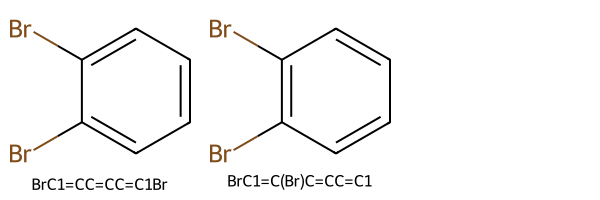

In [26]:
smls_aromatic_equivalent = ["C1=C(Br)C(Br)=CC=C1", "C1C(Br)=C(Br)C=CC=1"]
mols_aromatic_equivalent_unsanitized = [Chem.MolFromSmiles(sml, sanitize=False) for sml in smls_aromatic_equivalent]
canon_smls_aromatic_equivalent_unsanitized = [Chem.MolToSmiles(mol) for mol in mols_aromatic_equivalent_unsanitized]
Draw.MolsToGridImage(mols_aromatic_equivalent_unsanitized, legends=canon_smls_aromatic_equivalent_unsanitized)

and the two canonical SMILES are not the same

In [27]:
canon_smls_aromatic_equivalent_unsanitized[0] == canon_smls_aromatic_equivalent_unsanitized[1]

False

whereas if we do sanitize them, we get the same structure and canonical SMILES:

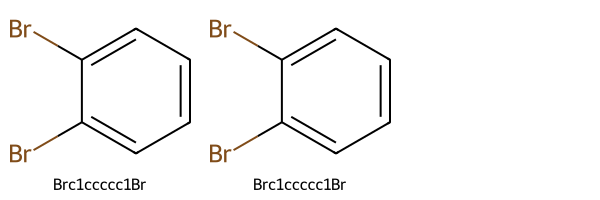

In [28]:
mols_aromatic_equivalent_sanitized = [Chem.MolFromSmiles(sml, sanitize=True) for sml in smls_aromatic_equivalent]
canon_smls_aromatic_equivalent_sanitized = [Chem.MolToSmiles(mol) for mol in mols_aromatic_equivalent_sanitized]
Draw.MolsToGridImage(mols_aromatic_equivalent_sanitized, legends=canon_smls_aromatic_equivalent_sanitized)

In [29]:
canon_smls_aromatic_equivalent_sanitized[0] == canon_smls_aromatic_equivalent_sanitized[1]

True

So the slight differences in the number of different structures as determined by RDKit compared to the tool used by Nicklaus and team (presumably their CACTVS tool) are probably due to the algorithms used to determine the molecular graph (from the input SMILES or other identifier) and then the canonical SMILES. Inspection by chemists of individual pairs would probably lead to better agreement of whether two similar structures are different, but the automatic adjudication required for large datasets is undoubtedly challenging to encode in an algorithm.

### InChI incorporating multiple tautomers 

["InChI is in principle designed to be tautomer-invariant"](https://cactus.nci.nih.gov/presentations/NIHInChI_2021-03/Day_1_Nicklaus_Tautomerism_2021-03-21A.pdf), meaning tautomers of a structure should be assigned the same InChI. Let's check how successful InChI is at that by performing the same operations we did on the SMILES columns (melting and removing duplicates), but using the InChI columns, and determining how many InChI are required to represent the structures.

In [30]:
df_melted_InChI = df.melt(id_vars=["Ref"], value_vars=cs.starts_with("Std_InChI_"), value_name="InChI")

# Keep rows where InChI is supplied
df_melted_InChI = df_melted_InChI.filter(pl.col('InChI').is_not_null())

# Remove InChI_n label column (n = 1-5)
df_melted_InChI = df_melted_InChI.drop("variable")

# Remove duplicate rows
df_melted_InChI = df_melted_InChI.unique()
unique_InChI = df_melted_InChI.shape[0]
df_melted_InChI

Ref,InChI
i64,str
4,"""InChI=1S/C7H6N…"
14,"""InChI=1S/C16H1…"
19,"""InChI=1S/C13H1…"
27,"""InChI=1S/C17H1…"
35,"""InChI=1S/C7H6O…"
45,"""InChI=1S/C6H8N…"
54,"""InChI=1S/C11H1…"
63,"""InChI=1S/C22H1…"
91,"""InChI=1S/C4H7N…"


So 3464 InChI are required to represent the 1776 sets of tautomers, whereas 3911 SMILES were. Let's check how well InChI does at representing multiple tautomers with a single identifier (InChI), compared to SMILES which does not have that goal or capability:

In [31]:
round(unique_InChI/Ref_count, 2)

1.95

In [32]:
round(unique_sml/Ref_count, 2)

2.2

In [33]:
# Calculate percent reduction
f"{(unique_sml - unique_InChI) / unique_sml:.0%}"

'11%'

So on average 1.95 InChI can represent a set of tautomers, compared to 2.2 SMILES, or an 11% reduction. Should InChI achieve its goal of being tautomer invariant, it would require only one InChI for a set of tautomers, which would be 1776 here. So InChI is only modestly successful.

## Enumerating tautomers using algorithms

Let's start enumerating tautomers using two RDKit algorithms. We'll define a function to create tautomers for a given enumerator class.

In [34]:
def tauts_as_sml_list(
        enumerator: Callable,
        sml: str,
    ) -> list[str]:
    """Use a tautomer enumerator to find the tautomers for a given SMILES
    
    :param enumerator: The tautomer enumerator class, which has an Enumerate method
    :param mol: An RDKit molecule
    :returns: A list of SMILES
    """
    mol = mol_from_sml(sml)
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

Now comes the computationally-intensive step of enumerating tautomers for each experimental structure (SMILES) using the two RDKit tautomer enumerators:

- TautomerEnumerator, the default class with the updated rules, which will also be our baseline
- GetV1TautomerEnumerator, the previous version

This step takes about 1.5 minutes on my laptop.

In [35]:
# Enumerate tautomers--this may take more than one minute
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("canon_sml").map_elements(lambda s: tauts_as_sml_list(enumerator(), s)).alias(f"tauts_{enumerator.__name__}"),
        ]
    )

In [36]:
df_melted.head(3)

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator
i64,str,str,list[str],list[str]
23,"""OC1=C(/C=N/C2=…","""O=[N+]([O-])c1…","[""O=C1C=NC=CC1C=Nc1ccc([N+](=O)[O-])cc1"", ""O=C1CN=CC=C1C=Nc1ccc([N+](=O)[O-])cc1"", … ""O=C1C=NC=CC1=CNc1ccc([N+](=O)[O-])cc1""]","[""O=C1C=NC=CC1C=Nc1ccc([N+](=O)[O-])cc1"", ""O=C1CN=CC=C1C=Nc1ccc([N+](=O)[O-])cc1"", … ""O=C1C=NC=CC1=CNc1ccc([N+](=O)[O-])cc1""]"
39,"""C1(/C=N/N2C=NN…","""C1=C/C(=C/Nc2c…","[""C1=CC(C=Nn2cnnc2)C(C=Nc2ccccc2)=C1"", ""C1=CC(=CNn2cnnc2)C(C=Nc2ccccc2)=C1"", … ""C1=CC(=CNc2ccccc2)C(C=Nn2cnnc2)=C1""]","[""C1=CC(C=Nn2cnnc2)C(C=Nc2ccccc2)=C1"", ""C1=CC(=CNn2cnnc2)C(C=Nc2ccccc2)=C1"", … ""C1=CC(=CNc2ccccc2)C(C=Nn2cnnc2)=C1""]"
85,"""[H]C12CC[C@@H]…","""CC1=NC2(O)C[C@…","[""CC1=NC2(O)C[C@H](C)CCC2C(C)(C)N1"", ""CC1=NC(C)(C)C2CC[C@@H](C)CC2(O)N1""]","[""CC1=NC2(O)C[C@H](C)CCC2C(C)(C)N1"", ""C=C1NC(C)(C)C2CC[C@@H](C)CC2(O)N1"", ""CC1=NC(C)(C)C2CC[C@@H](C)CC2(O)N1""]"


## Entering tautomers generated by external algorithms

For the NIH CACTUS Tautomerizer and CACTVS, I don't have programmatic access, so tautomers for some Refs are given below, either directly or read from a file.

### NIH Tautomerizer

[774.231241276]


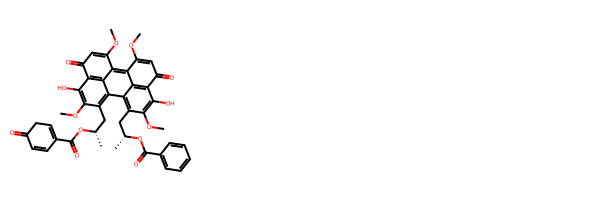

In [37]:
smls_check = [
    # "C=C(OCC)C1N(O)C(C)(C)C(C)=[N+]1[O-]" # input to site
    # "C=C(OCC)C1[NH+](C(C(N1O)(C)C)=C)[O-]", # an output from site
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)C6=CCC(=O)C=C6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54", # an entry in df_melted under tauts_NIH Ref 888
    # "C=C(/C=[N+](\[O-])C(C)(C)C(=C)NO)OCC", # an entry in df_melted under tauts_NIH Ref 1688
    # "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1", # input to site
    # "CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C", # an output from site
    # "CSC1=NC(=C2C=CC=CC2=[N+]([O-])O)C(C(=O)OC(C)C)=C(C)N1", # an entry in df_melted under tauts_NIH Ref 73
    ]
mols_check = [mol_from_sml(sml) for sml in smls_check]
wts_check = [Chem.CalcExactMolWt(mol) for mol in mols_check]
print(wts_check)
Draw.MolsToGridImage(mols_check)
# sml_canon_check = [Chem.MolToSmiles(mol) for mol in mols_check]
# [sml_canon == sml_canon_check[0] for sml_canon in sml_canon_check]

Breaker

In [38]:
# Manually list tautomers created by NIH Tautomerizer
# https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl
# Settings:
#   steps: multi
#   Predicted tautomers by: All Rules
nih_sml_tauts = {
    # 73a
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1": [
        "CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=C)N2",
        "CSC1=NC(C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)=C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C",
        "CSC1NC(=C(C(=N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(=C1C(C=CC=C1)=[N+]([O-])O)C(=C(C)N2)C(=O)OC(C)C",
        "CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C",
    ],
    # 73b
    "CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1": [
        # 4 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "CSC1=NC(C(=C(N1)C)C(=O)OC(C)C)C2=C(C=CC=C2)[N+](=O)[O-]",
        "CSC1=NC(C(C(=N1)C)C(=O)OC(C)C)C2=C(C=CC=C2)[N+](=O)[O-]",
        "CSC1=NC(C(C(N1)=C)C(=O)OC(C)C)C2=C(C=CC=C2)[N+](=O)[O-]",
        "CSC2=NC(=C)C(C(=O)OC(C)C)C(C1=C(C=CC=C1)[N+](=O)[O-])N2",
        # 1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "CSC1=NC(C(C(=N1)C)=C(O)OC(C)C)C2=C(C=CC=C2)[N+](=O)[O-]",
        # 2 tautomer(s) generated using PT_29_00 - nitro/aci-nitro via aromatic ring (2): 1,5 H-shift
        "CSC2=NC(=C(C(=O)OC(C)C)C(=C1C(C=CC=C1)=[N+]([O-])O)N2)C",
        "CSC2=NC(=C(C(=O)OC(C)C)C(=C1C(=CCC=C1)[N+]([O-])=O)N2)C",
    ],
    # 457a
    "[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(=O)c-3c(O[2H])c2O[2H])cc1O[2H]": [
        # 2 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=C(OC)C3=O)O[2H])[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        # 9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "O=C1C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)O[2H])O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3(C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])=O)[2H])O[2H]",
        "O([2H])C1(C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])=O)[2H]",
        "O=C1C(C=C(C=C1)C3=C(C(=C2C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)O[2H])O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C3(C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])=O)[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)[2H])=O)O[2H])O[2H]",
        # 2 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2=C(C(=C(C(=C2O3)[2H])O[2H])OC)O[2H])=O)O[2H])O[2H]",
        # 2 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "O=C1C(=CC(=CC1[2H])C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])O[2H]",
        "O([2H])C3=CC=C(C2=C(C(=C1C(C(=C(C(=C1O2)[2H])O[2H])OC)=O)O[2H])O[2H])C(C3=O)[2H]",
        # 1 tautomer(s) generated using PT_11_00 - 1,11 (aromatic) heteroatom H shift
        "O=C1C(=CC(C=C1)=C3C(=C(C2=C(C(=C(C(=C2O3)[2H])O[2H])OC)O[2H])O[2H])O[2H])O[2H]",
        # 1 tautomer(s) generated using PT_11_02 - 1,15 (aromatic) heteroatom H shift
        "O=C1C(=CC(C=C1)=C2C(=C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])O[2H])O[2H])O[2H]",
    ],
    # 457b
    "[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])cc1O[2H]": [
        # 9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(OC)(C3=O)[2H])[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2(C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)=O)[2H])O[2H]",
        "O([2H])C1(C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])=O)[2H]",
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(=C3O[2H])OC)[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(OC)(C3=O)[2H])[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C2(C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)=O)[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(OC)(C3=O)[2H])[2H])=O)O[2H])O[2H]",
        # 7 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "O=C1C(=CC(=CC1[2H])C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O([2H])C3=CC=C(C1=C(C(C2=C(O1)C(=C(O[2H])C(=C2O[2H])OC)[2H])=O)O[2H])C(C3=O)[2H]",
        "O=C1C(=CC(=CC1[2H])C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O=C1C(=CC(=CC1[2H])C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O=C1C(=CC(C=C1[2H])=C2C(=C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])O)O[2H])O[2H]",
        # 1 tautomer(s) generated using PT_10_00 - 1,9 (aromatic) heteroatom H shift
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])O[2H]",
    ],
    # 467a
    #   9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   7 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using PT_10_00 - 1,9 (aromatic) heteroatom H shift
    "O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12": [
        "O=C1C3=C(OC(C1=O)C2=CC(=C(C=C2)O)O)C=C(O)C=C3O",
        "O=C1C3=C(OC(=C1O)C2=CC(C(C=C2)=O)O)C=C(O)C=C3O",
        "O=C1C3=C(OC(=C1O)C2=CC(C(C=C2)O)=O)C=C(O)C=C3O",
        "O=C1C3=C(OC(=C1O)C2=CC(=C(C=C2)O)O)CC(=O)C=C3O",
        "O=C1C3=C(OC(=C1O)C2=CC(=C(C=C2)O)O)C=C(O)CC3=O",
        "O=C1C3=C(OC(C1=O)C2=CC(C(C=C2)=O)O)C=C(O)C=C3O",
        "O=C1C3=C(OC(C1=O)C2=CC(C(C=C2)O)=O)C=C(O)C=C3O",
        "O=C1C3=C(OC(C1=O)C2=CC(=C(C=C2)O)O)CC(=O)C=C3O",
        "O=C1C3=C(OC(C1=O)C2=CC(=C(C=C2)O)O)C=C(O)CC3=O",
        "OC2=C1C(=CC(C=C1OC(=C2O)C3=CC(=C(C=C3)O)O)=O)O",
        "O=C1C3=C(OC(=C1O)C2=CCC(=O)C(=C2)O)C=C(O)C=C3O",
        "O=C1C3=C(OC(=C1O)C2=CC=C(O)C(=O)C2)C=C(O)C=C3O",
        "O=C2C1=C(CC(C=C1OC(=C2O)C3=CC(=C(C=C3)O)O)=O)O",
        "O=C2C1C(C=C(C=C1OC(=C2O)C3=CC(=C(C=C3)O)O)O)=O",
        "OC2=C1C(=CC(C=C1OC(=C2O)C3=CCC(=O)C(=C3)O)=O)O",
        "OC2=C1C(=CC(C=C1OC(=C2O)C3=CC=C(O)C(=O)C3)=O)O",
        "OC2=C1C(C=C(C=C1OC(=C2O)C3=CC(=C(C=C3)O)O)O)=O",
    ],
    # 467b
    #   2 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
    #   9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   2 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   7 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using PT_11_00 - 1,11 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using PT_11_02 - 1,15 (aromatic) heteroatom H shift
    "O=c1cc(O)cc2oc(-c3ccc(O)c(O)c3)c(O)c(O)c1-2": [
        "O=C1C2=C(CC(=C1)O)OC(=C(O)C2=O)C3=CC(=C(C=C3)O)O",
        "OC2=C1C(C(=C(OC1=CC(=C2)O)C3=CC(=C(C=C3)O)O)O)=O",
        "O=C2C1=C(C(=C(OC1=CC(C2)=O)C3=CC(=C(C=C3)O)O)O)O",
        "O=C2C1=C(C(=C(OC1=CC(=C2)O)C3=CC(C(C=C3)=O)O)O)O",
        "O=C2C1=C(C(=C(OC1=CC(=C2)O)C3=CC(C(C=C3)O)=O)O)O",
        "O=C2C1=C(C(C(OC1=CC(=C2)O)C3=CC(=C(C=C3)O)O)=O)O",
        "O=C2C1C(C(=C(OC1=CC(=C2)O)C3=CC(=C(C=C3)O)O)O)=O",
        "O=C2C1=C(C(=C(OC1=CC(C2)=O)C3=CC(C(C=C3)=O)O)O)O",
        "O=C2C1=C(C(=C(OC1=CC(C2)=O)C3=CC(C(C=C3)O)=O)O)O",
        "O=C2C1=C(C(C(OC1=CC(C2)=O)C3=CC(=C(C=C3)O)O)=O)O",
        "O=C2C1C(C(=C(OC1=CC(C2)=O)C3=CC(=C(C=C3)O)O)O)=O",
        "OC2=C1C(C(=C(OC1=CC(=C2)O)C3=CC(=C(C=C3)O)O)O)=O",
        "OC1=CC(=O)C=C2C1=C(C(=C(O2)C3=CC(=C(C=C3)O)O)O)O",
        "O=C1C2=C(C=C(C1)O)OC(=C(O)C2=O)C3=CC(=C(C=C3)O)O",
        "O=C2C1=C(C(=C(OC1=CC(=C2)O)C3=CCC(=O)C(=C3)O)O)O",
        "O=C2C1=C(C(=C(OC1=CC(=C2)O)C3=CC=C(O)C(=O)C3)O)O",
        "OC2=C1C(C(=C(OC1=CC(=C2)O)C3=CC(=C(C=C3)O)O)O)=O",
        "OC2=C1C(C(=C(OC1=CC(C2)=O)C3=CC(=C(C=C3)O)O)O)=O",
        "O=C1C2=C(C=C(C1)O)OC(=C(O)C2=O)C3=CCC(=O)C(=C3)O",
        "O=C1C2=C(C=C(C1)O)OC(=C(O)C2=O)C3=CC=C(O)C(=O)C3",
        "OC2=C1C(=C(C(OC1=CC(=C2)O)=C3C=C(C(C=C3)=O)O)O)O",
        "OC1=CC(=CC2=C1C(=C(C(O2)=C3C=C(C(C=C3)=O)O)O)O)O",
        ],
    # 888a
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54": [
        # 5 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "COC4=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC4=C6C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC5=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC5=C6C3=C1C(=C(C(C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)=O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC5=C6C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        # 2 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
        "COC5=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC5=C6C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        # 6 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "COC5=C(O)C1=C(O)C=C(OC)C2=C1C6=C3C(=C(C(=C4C(C=C(C2=C34)OC)=O)O)OC)[C@H](C(=C56)[C@H](C)O)[C@H](C)O",
        "COC5=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C(CC(C(=C34)C5=O)=O)OC)OC)=O)O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC2=C6C3=C1C(=C(C(C5=C1C(=C4C(=CC(C(=C2O)C34)=O)OC)C(=CC5=O)OC)=O)OC)[C@H]([C@@H]6[C@H](C)O)[C@H](C)O",
        "COC5=C(O)C4=C3C6=C1C(=C(C(=C2C(C=C(C(=C12)C3=C(CC4=O)OC)OC)=O)O)OC)[C@H](C(=C56)[C@H](C)O)[C@H](C)O",
        "COC5=C(O)C1=C(O)C=C(OC)C3=C1C6=C2C(=C(C(C4=C2C3=C(OC)CC4=O)=O)OC)[C@H](C(=C56)[C@H](C)O)[C@H](C)O",
        "COC2=C(O)C1=C(O)C=C(OC)C4=C1C3=C5C(=C(C(=C23)[C@H](C)O)[C@H](C)O)C(=C(C6=C(C=C(C4=C56)OC)O)O)OC",
    ],
    # 888b
    "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O": [
        "COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O",
        "COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC3=C2[C@H]([C@@H](C1=C(OC)C(=C6C5=C1C2=C4C(=C3O)C(C=C(C4=C5C(=CC6=O)OC)OC)=O)O)[C@H](C)O)[C@H](C)O",
        "COC2=C3[C@H]([C@@H](C4=C(OC)C(=O)C6=C5C(=C1C(C(=C(C=C1OC)O)C2=O)C3=C45)C(=CC6=O)OC)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5=C3C1=C2C(=C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5C3=C1C2=C(C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
    ],
    # 890a
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54": [
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC6=C(O)C1=C(O)C=C(OC)C2=C1C(=C3C(=C(C(=C4C(C=C(C2=C34)OC)=O)O)OC)C[C@H](C)OC(=O)C5=CC=C(C=C5)O)C6=C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C(CC(C(=C34)C5=O)=O)OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C1C(=C(OC)CC2=O)C5=C3C(=C4O)C(=O)C=C5OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(C(=C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)O)OC)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC2=C(C3=C1C(=C(C(C5=C1C(=C4C(=CC(C(=C2O)C34)=O)OC)C(=CC5=O)OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC3=C(C1=C4C(=C(C(=C5C(C=C(C(=C2C(=CC(C(=C12)C3=O)=O)OC)C45)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
    ],
    # 890b
    #   3 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
    #   7 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   3 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   6 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    "COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43": [
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(=C(C(C3=C45)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)O)OC)OC)O)C7=O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(C(=C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)O)O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(=C(C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)=C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)O)OC)OC)O)O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5=C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)=O)OC)OC)O)C7=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(=C6C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(C6=C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)=O)OC)OC)=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(=O)C3=CC=C(C=C3)O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(O)=C3C=CC(C=C3)=O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(O)=C7C=CC(C=C7)=O)OC)=O)O)OC",
    ],
    # 891a
    #   6 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   3 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   9 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54": [
        "COC4=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC4=C6C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC4=C6C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC4=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C(C(C6)(C)O)=C(C)O",
        "COC4=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)[C@@H](C(C6)(C)O)C(=C)O",
        "COC5=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC5=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC4=C6C3=C1C(=C(C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)=O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC5=C6C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC5=C(O)C1=C(O)C=C(OC)C2=C1C6=C3C(=C(C(=C4C(C=C(C2=C34)OC)=O)O)OC)[C@@H](C(C=C56)(C)O)C(C)=O",
        "COC5=C6C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C(CC(C(=C34)C5=O)=O)OC)OC)=O)O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC4=C6C3=C1C(=C(C(C2=C1C(=C(OC)CC2=O)C5=C3C(=C4O)C(=O)C=C5OC)=O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC5=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C6=C4C(=C5O)C(=O)C=C6OC)OC)O)O)OC",
        "COC2=C6C3=C1C(=C(C(C5=C1C(=C4C(=CC(C(=C2O)C34)=O)OC)C(=CC5=O)OC)=O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC3=C6C1=C4C(=C(C(=C5C(C=C(C(=C2C(=CC(C(=C12)C3=O)=O)OC)C45)OC)=O)O)OC)[C@@H](C(C6)(C)O)C(C)=O",
        "COC5=C(O)C4=C3C6=C1C(=C(C(=C2C(C=C(C(=C12)C3=C(CC4=O)OC)OC)=O)O)OC)[C@@H](C(C=C56)(C)O)C(C)=O",
        "COC5=C(O)C1=C(O)C=C(OC)C3=C1C6=C2C(=C(C(C4=C2C3=C(OC)CC4=O)=O)OC)[C@@H](C(C=C56)(C)O)C(C)=O",
        "COC2=C(O)C1=C(O)C=C(OC)C4=C1C3=C5C(=C(C(C=C23)(C)O)C(C)=O)C(=C(C6=C(C=C(C4=C56)OC)O)O)OC",
    ],
    # 891b
    #   3 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
    #   6 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   3 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   3 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2": [
        "COC4=C1CC(C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)C(C)=O)(C)O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(C(=C6C(=C12)C(=C34)C5=CC([C@H]6C(C)=O)(C)O)OC)=O)O)OC)OC)O)O",
        "COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C(C(C)=O)C(C)(O)C=C1C(=C23)C4=C56)OC)O)O)OC)OC)O)O",
        "COC6=C2CC([C@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)C(C)=O)(C)O",
        "COC6=C1CC([C@H](C2=C(OC)C(=O)C3=C(O)C=C(OC)C4=C5C(=C1C2=C34)C(C(C=C5OC)=O)C6=O)C(C)=O)(C)O",
        "COC6=C2CC([C@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)C(C)=O)(C)O",
        "COC6=C1CC(C(C2=C(OC)C(=O)C3=C(O)C=C(OC)C4=C5C(=C1C2=C34)C(=C(C=C5OC)O)C6=O)=C(C)O)(C)O",
        "COC6=C1CC([C@H](C2=C(OC)C(=O)C3=C(O)C=C(OC)C4=C5C(=C1C2=C34)C(=C(C=C5OC)O)C6=O)C(=C)O)(C)O",
        "COC6=C2CC([C@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)C(C)=O)(C)O",
        "COC6=C2CC([C@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)C(C)=O)(C)O",
        "COC5=C1CC([C@H](C2=C(OC)C(=O)C3=C(O)C=C(OC)C4=C6C(=C1C2=C34)C(=C5O)C(C=C6OC)=O)C(C)=O)(C)O",
        "COC3=C2CC([C@H](C1=C(OC)C(=C6C5=C1C2=C4C(=C3O)C(C=C(C4=C5C(=CC6=O)OC)OC)=O)O)C(C)=O)(C)O",
        "COC2=C3CC([C@H](C4=C(OC)C(=O)C6=C5C(=C1C(C(=C(C=C1OC)O)C2=O)C3=C45)C(=CC6=O)OC)C(C)=O)(C)O",
        "COC2=C3CC([C@H](C4=C(OC)C(=O)C5=C(O)C=C(OC)C6=C1C(=C(C(C=C1OC)=O)C2=O)C3=C4C56)C(C)=O)(C)O",
        "COC6=C1CC([C@H](C5=C3C1=C2C(=C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)O)C6=O)C(C)=O)(C)O",
    ],
    # 1512a
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    "CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1": [
        "CC[P]2(OC1C(=CC(=CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P]2(OC1=C(C=C(CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P](CC)(C1=CC=CC=C1)=NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O",
    ],
    # 1512b
    "CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1": [
        "CC[P](CC)(=NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC[P](CC)(=NC1=CC(=CC(C(C)(C)C)C1=O)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C5=CC=CC=C5",
        "CC[P]5(CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O5)C6=CC=CC=C6",
    ],

    # 1688a
    #   1 tautomer(s) generated using PT_03_00 - simple (aliphatic) imine
    #   2 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_16_00 - nitroso/oxime
    #   1 tautomer(s) generated using PT_36_00 - oxime/nitrone: 1,2 H-shift
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(/C=[N+](\[O-])C(C)(C)/C(C)=N/O)OCC": [
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)=[NH+][O-])OCC",
        "C=C(C1N(O)C(C)(C)C(=[N+]1[O-])C)OCC",
    ],
    # 1688b
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_39_00 - nitrone/azoxy or Behrend rearrangement
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(OCC)C1N(O)C(C)(C)C(C)=[N+]1[O-]": [
        "C=C(OCC)C1[NH+](C(C(N1O)(C)C)=C)[O-]",
        "C=C(OCC)C1=[N+](C(C(N1O)(C)C)C)[O-]",
        "C=C(OCC)C=[N+]([O-])C(C)(C)C(C)=NO",
    ],
    # 1704 a
    "Cc1cc(C=O)c(C)c(C=O)c1": [
        "CC1=CC(C(C(=C1)C=O)=C)=CO",
        "C[CH]1C=C([C](C(=C1)C=O)=[CH2])C=O",
    ],
    # 1704 b
    "C=c1c(C=O)cc(C)cc1=CO": [
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
        "C=C1C(C=C(C=C1C=O)C)C=O",
        "C=C1C(=CC(=CC1C=O)C)C=O",
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
    ],
}

In [39]:
# Function to canonicalize a list of SMILES
def canonicalize_smiles(smls_list: list[str]) -> list[str]:
    """
    Canonicalize a list of SMILES, trying first with and then without sanitization;
    convert list into a set to remove duplicates, then back to a list so can go in dataframe

    :param smls_list: List of SMILES strings
    :returns: List of canonical SMILES strings
    """
    canonical_smiles = []
    for sml in smls_list:
        mol = Chem.MolFromSmiles(sml)
        if mol:
            canonical = Chem.MolToSmiles(mol)
            canonical_smiles.append(canonical)
        else:
            mol = Chem.MolFromSmiles(sml, sanitize=False)
            if mol:
                canonical = Chem.MolToSmiles(mol)
                canonical_smiles.append(canonical)
            else:
                # canonical_smiles.append(None) #? This shouldn't be here, correct?
                print("Molecule couldn't be created")
    # Eliminate duplicates by turning list into a set, then back to a list so can go in dataframe
    canonical_smiles_unique = list(set(canonical_smiles))
    return canonical_smiles_unique

In [40]:
# Prepare tautomer data from NIH web site
nih_sml_tauts_canon = {key: canonicalize_smiles(value) for key, value in nih_sml_tauts.items()}
nih_inputs = nih_sml_tauts_canon.keys()
nih_tauts = nih_sml_tauts_canon.values()
df_nih = pl.DataFrame({"canon_sml": nih_inputs, "tauts_NIH": nih_tauts})
df_nih

canon_sml,tauts_NIH
str,list[str]
"""CSC1=NC(c2cccc…","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"
"""CSC1=NC(C)=C(C…","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CCC=C2[N+](=O)[O-])N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CC=CC2=[N+]([O-])O)N1""]"
"""[2H]Oc1ccc(-c2…","[""[2H]OC1=C(OC)C(=O)c2c(oc(-c3ccc(O[2H])c(O[2H])c3)c(O[2H])c2=O)C1([2H])[2H]"", ""[2H]OC1=C2C(=O)C([2H])(OC)C(=O)C([2H])=C2OC(c2ccc(O[2H])c(O[2H])c2)=C1O[2H]"", … ""[2H]Oc1ccc(-c2oc3c([2H])c(=O)c(OC)c(O[2H])c-3c(O[2H])c2O[2H])cc1O[2H]""]"
"""[2H]Oc1ccc(-c2…","[""[2H]OC1=CC(c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])=CC([2H])C1=O"", ""[2H]Oc1ccc(C2([2H])Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(=O)C2=O)cc1O[2H]"", … ""[2H]Oc1c(OC)c(O[2H])c2c(=O)c(O[2H])c(C3=CC(=O)C([2H])(O[2H])C=C3)oc2c1[2H]""]"
"""O=c1c(O)c(-c2c…","[""O=C1C(=O)C(C2=CC(O)C(=O)C=C2)Oc2cc(O)cc(O)c21"", ""O=C1CC(O)=CC2=C1C(=O)C(=O)C(c1ccc(O)c(O)c1)O2"", … ""O=C1C=C(c2oc3cc(O)cc(O)c3c(=O)c2O)C=CC1O""]"
"""O=c1cc(O)cc2oc…","[""O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12"", ""O=C1C=C2OC(c3ccc(O)c(O)c3)=C(O)C(O)=C2C(=O)C1"", … ""O=C1C=C(O)Cc2oc(-c3ccc(O)c(O)c3)c(O)c(=O)c21""]"
"""COc1c(O)c2c(=O…","[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", ""COC1=C2c3c4c(c5c(OC)cc(O)c6c(O)c(OC)c(c3c65)=C([C@H](C)O)[C@@H]2[C@H](C)O)=C(OC)CC(=O)C=4C1=O"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54""]"
"""COc1c2c3c4c(c(…","[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", ""COC1=CC(=O)C2=c3c1c1c(OC)cc(=O)c4c(=O)c(OC)c5c(c3C(C(OC)=C2O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)c1=4"", … ""COC1=C2c3c4c(c(O)cc(OC)c4c4c(OC)cc(O)c5c(O)c(OC)c(c3c54)=C([C@H](C)O)[C@@H]2[C@H](C)O)C1=O""]"
"""COc1c(O)c2c(=O…","[""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)c1ccc(O)cc1"", ""COC1=c2c3c(c(=O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c3c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(O)c4c(=O)cc(OC)c2c43)C(=O)C1"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@H](C)OC(=O)C4=CCC(=O)C=C4)c32)C(=O)C=C1OC""]"


Now we merge in the NIH tautomers by left-joining on canonical SMILES.

In [41]:
# Ensure no tautsNIH columns already exist--can cause additional column tautsNIH_right to be created
df_melted = df_melted.drop(cs.starts_with('tauts_NIH'))

df_melted = df_melted.join(df_nih, on="canon_sml", how="left")

To inspect the results and check which Refs are included, let's display one row for each Ref.

In [42]:
# sml = "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O"
# sml = "COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O"
sml = "CSC1=NC(=C2C=CC=CC2=[N+]([O-])O)C(C(=O)OC(C)C)=C(C)N1"
df_melted.filter(pl.col("tauts_NIH").list.contains(sml))

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,str,str,list[str],list[str],list[str]
73,"""O=[N+](C1=C(C2…","""CSC1=NC(c2cccc…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"


In [100]:
df_melted.filter(pl.col("tauts_NIH").is_not_null()).sort("Ref")

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,str,str,list[str],list[str],list[str]
73,"""O=[N+](C1=C(C2…","""CSC1=NC(C)=C(C…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CCC=C2[N+](=O)[O-])N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CC=CC2=[N+]([O-])O)N1""]"
73,"""O=[N+](C1=C(C2…","""CSC1=NC(c2cccc…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"
457,"""O=C2C1=C(O[2H]…","""[2H]Oc1ccc(-c2…","[""[2H]O=C1CC=C(C2OC3=C([2H])C(=O[2H])C(OC)=C([OH][2H])C3C(=O)C2=O[2H])CC1=O[2H]"", ""[2H]Oc1ccc(C2OC3=C(C(=O)C2=O[2H])C(=O[2H])C(OC)C([OH][2H])=C3[2H])cc1[OH][2H]"", … ""[2H]O=C1C(OC)=C([OH][2H])C2=C(OC(c3ccc([OH][2H])c([OH][2H])c3)C(=O[2H])C2=O)C1[2H]""]","[""[2H]OC1=C(C2=CC(=O[2H])C(=O[2H])C=C2)OC2=C([2H])C(=O[2H])C(OC)C(O[2H])=C2C1O"", ""[2H]OC1c2c(oc(C3=CC(=O[2H])C(=O[2H])C=C3)c([OH][2H])c2=O)C([2H])=C([OH][2H])C1OC"", … ""[2H]OC1=CC(C2Oc3c([2H])c([OH][2H])c(OC)c([OH][2H])c3C(=O)C2=O[2H])C=CC1=O[2H]""]","[""[2H]OC1=CC(c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])=CC([2H])C1=O"", ""[2H]Oc1ccc(C2([2H])Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(=O)C2=O)cc1O[2H]"", … ""[2H]Oc1c(OC)c(O[2H])c2c(=O)c(O[2H])c(C3=CC(=O)C([2H])(O[2H])C=C3)oc2c1[2H]""]"
457,"""O=C(C(OC)=C(C(…","""[2H]Oc1ccc(-c2…","[""[2H]OC1=CC(=C2OC3=C([2H])C(=O[2H])C(OC)C(=O)C3C(O[2H])=C2O[2H])C=CC1=O[2H]"", ""[2H]OC1=CC(c2oc3c(c(=O[2H])c2O[2H])C(=O)C(OC)C(=O[2H])C3[2H])C=CC1=O[2H]"", … ""[2H]OC1=CC=C(c2oc3c([2H])c([OH][2H])c(OC)c(O)c3c(=O[2H])c2O[2H])CC1=O[2H]""]","[""[2H]OC1=CC(=C2OC3=C([2H])C(=O[2H])C(OC)C(=O)C3C(O[2H])=C2O[2H])C=CC1=O[2H]"", ""[2H]Oc1c([2H])c2oc(C3=CC(=O[2H])C(=O[2H])CC3)c([OH][2H])c([OH][2H])c-2c(=O)c1OC"", … ""[2H]OC1=CC(=C2Oc3c([2H])c([OH][2H])c(OC)c(O)c3C(=O[2H])C2O[2H])C=CC1=O[2H]""]","[""[2H]OC1=C(OC)C(=O)c2c(oc(-c3ccc(O[2H])c(O[2H])c3)c(O[2H])c2=O)C1([2H])[2H]"", ""[2H]OC1=C2C(=O)C([2H])(OC)C(=O)C([2H])=C2OC(c2ccc(O[2H])c(O[2H])c2)=C1O[2H]"", … ""[2H]Oc1ccc(-c2oc3c([2H])c(=O)c(OC)c(O[2H])c-3c(O[2H])c2O[2H])cc1O[2H]""]"
467,"""O=C1C2=C(C=C(C…","""O=c1c(O)c(-c2c…","[""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", ""O=C1CCC(=C2OC3=C(C(=O)CC(O)=C3)C(=O)C2=O)C=C1O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C=CC(C2OC3=CC(O)C=C(O)C3=C(O)C2=O)=CC1=O"", ""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C(=O)C(C2=CC(O)C(=O)C=C2)Oc2cc(O)cc(O)c21"", ""O=C1CC(O)=CC2=C1C(=O)C(=O)C(c1ccc(O)c(O)c1)O2"", … ""O=C1C=C(c2oc3cc(O)cc(O)c3c(=O)c2O)C=CC1O""]"
467,"""OC1=C2C(C=C(O)…","""O=c1cc(O)cc2oc…","[""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", ""O=C1CCC(=C2OC3=C(C(=O)CC(O)=C3)C(=O)C2=O)C=C1O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C=CC(C2OC3=CC(O)C=C(O)C3=C(O)C2=O)=CC1=O"", ""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12"", ""O=C1C=C2OC(c3ccc(O)c(O)c3)=C(O)C(O)=C2C(=O)C1"", … ""O=C1C=C(O)Cc2oc(-c3ccc(O)c(O)c3)c(O)c(=O)c21""]"
888,"""O=C1C(C(O)=C2O…","""COc1c(O)c2c(=O…","[""COC1=c2c3c(OC)cc(O)c4c3c3c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c(c2c53)C(=O)C1)C(OC)C4=O"", ""COC1=c2c

In [109]:
refs_nih_raw = df_melted.filter(pl.col("tauts_NIH").is_not_null())["Ref"].to_list()
refs_nih = list(set(refs_nih_raw))
refs_nih.sort()
print(f"{refs_nih=}")

refs_nih=[73, 457, 467, 888, 890, 891, 1512, 1688, 1704]


In [110]:
df_melted.filter(pl.col("Ref").is_in(refs_nih)).sort("Ref")

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,str,str,list[str],list[str],list[str]
73,"""O=[N+](C1=C(C2…","""CSC1=NC(C)=C(C…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CCC=C2[N+](=O)[O-])N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CC=CC2=[N+]([O-])O)N1""]"
73,"""O=[N+](C1=C(C2…","""CSC1=NC(c2cccc…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"
457,"""O=C2C1=C(O[2H]…","""[2H]Oc1ccc(-c2…","[""[2H]O=C1CC=C(C2OC3=C([2H])C(=O[2H])C(OC)=C([OH][2H])C3C(=O)C2=O[2H])CC1=O[2H]"", ""[2H]Oc1ccc(C2OC3=C(C(=O)C2=O[2H])C(=O[2H])C(OC)C([OH][2H])=C3[2H])cc1[OH][2H]"", … ""[2H]O=C1C(OC)=C([OH][2H])C2=C(OC(c3ccc([OH][2H])c([OH][2H])c3)C(=O[2H])C2=O)C1[2H]""]","[""[2H]OC1=C(C2=CC(=O[2H])C(=O[2H])C=C2)OC2=C([2H])C(=O[2H])C(OC)C(O[2H])=C2C1O"", ""[2H]OC1c2c(oc(C3=CC(=O[2H])C(=O[2H])C=C3)c([OH][2H])c2=O)C([2H])=C([OH][2H])C1OC"", … ""[2H]OC1=CC(C2Oc3c([2H])c([OH][2H])c(OC)c([OH][2H])c3C(=O)C2=O[2H])C=CC1=O[2H]""]","[""[2H]OC1=CC(c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])=CC([2H])C1=O"", ""[2H]Oc1ccc(C2([2H])Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(=O)C2=O)cc1O[2H]"", … ""[2H]Oc1c(OC)c(O[2H])c2c(=O)c(O[2H])c(C3=CC(=O)C([2H])(O[2H])C=C3)oc2c1[2H]""]"
457,"""O=C(C(OC)=C(C(…","""[2H]Oc1ccc(-c2…","[""[2H]OC1=CC(=C2OC3=C([2H])C(=O[2H])C(OC)C(=O)C3C(O[2H])=C2O[2H])C=CC1=O[2H]"", ""[2H]OC1=CC(c2oc3c(c(=O[2H])c2O[2H])C(=O)C(OC)C(=O[2H])C3[2H])C=CC1=O[2H]"", … ""[2H]OC1=CC=C(c2oc3c([2H])c([OH][2H])c(OC)c(O)c3c(=O[2H])c2O[2H])CC1=O[2H]""]","[""[2H]OC1=CC(=C2OC3=C([2H])C(=O[2H])C(OC)C(=O)C3C(O[2H])=C2O[2H])C=CC1=O[2H]"", ""[2H]Oc1c([2H])c2oc(C3=CC(=O[2H])C(=O[2H])CC3)c([OH][2H])c([OH][2H])c-2c(=O)c1OC"", … ""[2H]OC1=CC(=C2Oc3c([2H])c([OH][2H])c(OC)c(O)c3C(=O[2H])C2O[2H])C=CC1=O[2H]""]","[""[2H]OC1=C(OC)C(=O)c2c(oc(-c3ccc(O[2H])c(O[2H])c3)c(O[2H])c2=O)C1([2H])[2H]"", ""[2H]OC1=C2C(=O)C([2H])(OC)C(=O)C([2H])=C2OC(c2ccc(O[2H])c(O[2H])c2)=C1O[2H]"", … ""[2H]Oc1ccc(-c2oc3c([2H])c(=O)c(OC)c(O[2H])c-3c(O[2H])c2O[2H])cc1O[2H]""]"
467,"""O=C1C2=C(C=C(C…","""O=c1c(O)c(-c2c…","[""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", ""O=C1CCC(=C2OC3=C(C(=O)CC(O)=C3)C(=O)C2=O)C=C1O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C=CC(C2OC3=CC(O)C=C(O)C3=C(O)C2=O)=CC1=O"", ""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C(=O)C(C2=CC(O)C(=O)C=C2)Oc2cc(O)cc(O)c21"", ""O=C1CC(O)=CC2=C1C(=O)C(=O)C(c1ccc(O)c(O)c1)O2"", … ""O=C1C=C(c2oc3cc(O)cc(O)c3c(=O)c2O)C=CC1O""]"
467,"""OC1=C2C(C=C(O)…","""O=c1cc(O)cc2oc…","[""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", ""O=C1CCC(=C2OC3=C(C(=O)CC(O)=C3)C(=O)C2=O)C=C1O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C=CC(C2OC3=CC(O)C=C(O)C3=C(O)C2=O)=CC1=O"", ""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12"", ""O=C1C=C2OC(c3ccc(O)c(O)c3)=C(O)C(O)=C2C(=O)C1"", … ""O=C1C=C(O)Cc2oc(-c3ccc(O)c(O)c3)c(O)c(=O)c21""]"
888,"""O=C1C(C(O)=C2O…","""COc1c(O)c2c(=O…","[""COC1=c2c3c(OC)cc(O)c4c3c3c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c(c2c53)C(=O)C1)C(OC)C4=O"", ""COC1=c2c

In [43]:
df_melted.filter(pl.col("tauts_NIH").is_not_null()).unique(subset="Ref").sort("Ref")

Ref,sml,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,str,str,list[str],list[str],list[str]
73,"""O=[N+](C1=C(C2…","""CSC1=NC(C)=C(C…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CCC=C2[N+](=O)[O-])N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CC=CC2=[N+]([O-])O)N1""]"
457,"""O=C2C1=C(O[2H]…","""[2H]Oc1ccc(-c2…","[""[2H]O=C1CC=C(C2OC3=C([2H])C(=O[2H])C(OC)=C([OH][2H])C3C(=O)C2=O[2H])CC1=O[2H]"", ""[2H]Oc1ccc(C2OC3=C(C(=O)C2=O[2H])C(=O[2H])C(OC)C([OH][2H])=C3[2H])cc1[OH][2H]"", … ""[2H]O=C1C(OC)=C([OH][2H])C2=C(OC(c3ccc([OH][2H])c([OH][2H])c3)C(=O[2H])C2=O)C1[2H]""]","[""[2H]OC1=C(C2=CC(=O[2H])C(=O[2H])C=C2)OC2=C([2H])C(=O[2H])C(OC)C(O[2H])=C2C1O"", ""[2H]OC1c2c(oc(C3=CC(=O[2H])C(=O[2H])C=C3)c([OH][2H])c2=O)C([2H])=C([OH][2H])C1OC"", … ""[2H]OC1=CC(C2Oc3c([2H])c([OH][2H])c(OC)c([OH][2H])c3C(=O)C2=O[2H])C=CC1=O[2H]""]","[""[2H]OC1=CC(c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])=CC([2H])C1=O"", ""[2H]Oc1ccc(C2([2H])Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(=O)C2=O)cc1O[2H]"", … ""[2H]Oc1c(OC)c(O[2H])c2c(=O)c(O[2H])c(C3=CC(=O)C([2H])(O[2H])C=C3)oc2c1[2H]""]"
467,"""O=C1C2=C(C=C(C…","""O=c1c(O)c(-c2c…","[""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", ""O=C1CCC(=C2OC3=C(C(=O)CC(O)=C3)C(=O)C2=O)C=C1O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C=CC(C2OC3=CC(O)C=C(O)C3=C(O)C2=O)=CC1=O"", ""O=C1CC(=O)C2=C(C1)OC(C1=CC(=O)C(=O)C=C1)C(O)C2=O"", … ""O=C1C=CC(=C2OC3=CC(O)=CC(=O)C3C(O)=C2O)CC1=O""]","[""O=C1C(=O)C(C2=CC(O)C(=O)C=C2)Oc2cc(O)cc(O)c21"", ""O=C1CC(O)=CC2=C1C(=O)C(=O)C(c1ccc(O)c(O)c1)O2"", … ""O=C1C=C(c2oc3cc(O)cc(O)c3c(=O)c2O)C=CC1O""]"
888,"""O=C1C(C(O)=C2O…","""COc1c(O)c2c(=O…","[""COC1=c2c3c(OC)cc(O)c4c3c3c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c(c2c53)C(=O)C1)C(OC)C4=O"", ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c6c(c2=C(OC)CC6=O)c54)=C(OC)C(=O)C3C(=O)C1"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c(O)c(OC)c(c4c21)=C([C@H](C)O)C3[C@H](C)O""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1C([C@H](C)O)C6[C@H](C)O)c23)c54"", ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c6c([C@H](C)O)c([C@H](C)O)c1c(c23)c6c54"", … ""COC1=C2c3c4c(c(O)cc(OC)c4c4c(OC)cc(O)c5c(O)c(OC)c(c3c54)=C([C@H](C)O)C2[C@H](C)O)C1=O""]","[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", ""COC1=C2c3c4c(c5c(OC)cc(O)c6c(O)c(OC)c(c3c65)=C([C@H](C)O)[C@@H]2[C@H](C)O)=C(OC)CC(=O)C=4C1=O"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54""]"
890,"""O=C(C=C1OC)C2=…","""COc1c(O)c2c(=O…","[""COC1=c2c3c(c4c5c(c(O)cc(OC)c25)C(=O)C(OC)C4=C[C@H](C)OC(O)=C2C=CC(=O)C=C2)C(=C[C@@H](C)OC(=O)c2ccccc2)C(OC)C(=O)C=3C(=O)C1"", ""COC1=C(C[C@@H](C)OC(=O)c2ccccc2)c2c3c4c(c5c2=C(C(=O)CC=5OC)C1=O)=C(OC)CC(=O)C=4C(=O)C(OC)C3=C[C@H](C)OC(=O)C1C=CC(=O)C=C1"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)C3=CCC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]","[""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c(=C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1=C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(c1=O)C(=O)CC(OC)c3c1c(OC)cc(=O)c3c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c2c13"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)C3=CCC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]","[""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c1c32)C(OC)=CC(=O)C5C(=O)C(OC)=C4C[C@H](C)OC(=O)c1ccc(O)cc1"", ""COC1=c2c3c(c(=O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c3c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(O)c4c(=O)cc(OC)c2c43)C(=O)C1"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)

Now let's merge the several rows for each Ref by putting the tautomers into lists.

In [44]:
df_melted_aggregated = (
    # Aggregate by combining multiple lists into a single flat list
    df_melted.group_by('Ref')
    .agg(["canon_sml", cs.starts_with("tauts_").explode()])
# Keep the unique elements in each list; that is, remove duplicates
).with_columns(cs.starts_with("tauts_").list.unique())
df_melted_aggregated.filter(pl.col("Ref").is_in([73, 888, 1704])).sort("Ref")

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH
i64,list[str],list[str],list[str],list[str]
73,"[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]","[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", … ""C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(=C2C=CCC=C2[N+](=O)[O-])N1""]"
888,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O""]","[""COC1=CC(=O)C2C(O)=C(OC)C3=C([C@H](C)O)C([C@H](C)O)C4=c5c3c2c1c1c5=C(C(=O)C=C1OC)C(=O)C4OC"", ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c6c(O)cc(OC)c2c6c54)C(OC)C(=O)C=3C(=O)C1"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c5c6c(c1c42)C(OC)=CC(=O)C6C(=O)C(OC)C5=C([C@H](C)O)C3[C@H](C)O""]","[""C=C(O)c1c2c3c4c(c5c6c3c(c1=C(C)O)C(OC)C(=O)C=6C(=O)CC5OC)C(OC)C=C(O)C4C(O)=C2OC"", ""COC1=c2c(C(C)O)c(C(C)=O)c3c4c5c(c6c(c24)C(=C(O)CC6OC)C1=O)C(OC)CC(=O)C5C(=O)C=3OC"", … ""C=C(O)c1c(C(C)O)c2c(OC)c(O)c3c4c(c5c6c(c1C(OC)C(=O)C=6C(O)=CC5OC)c24)C(OC)C=C3O""]","[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O"", … ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)C41""]"
1704,"[""C=c1c(C=O)cc(C)cc1=CO"", ""Cc1cc(C=O)c(C)c(C=O)c1""]","[""Cc1cc(C=O)c(C)c(C=O)c1"", ""C=c1c(C=O)cc(C)cc1=CO"", ""C=C1C(C=O)=CC(C)=CC1C=O""]","[""Cc1cc(C=O)c(C)c(C=O)c1"", ""C=c1c(C=O)cc(C)cc1=CO""]","[""C=C1C(C=O)=CC(C)C=C1C=O"", ""C=c1c(C=O)cc(C)cc1=CO"", … ""Cc1cc(C=O)c(C)c(C=O)c1""]"


### CACTVS

The CACTVS results provided by Marc Nicklaus are in [SDF (structure-data format)](https://en.wikipedia.org/wiki/Chemical_table_file#SDF), so this function extracts the Ref and number (1 or 2, used to identify different experimentally-observed structures).

In [45]:
def extract_ref(
    e_name: str,
):
    """Extract the reference number from an E_NAME entry in an SDF file, for example
    > <E_NAME>
    Ref_0890_01_1
    has e_name of
    Ref_0890_01_1
    which returns
    890

    :param e_name: The E_NAME property, for example "Ref_0890_01_1"
    """
    parts = e_name.split("_")
    ref_str = parts[1]
    try:
        ref = int(ref_str)
    except:
        ref = None
    return ref

This code actually reads the SDF files into lists.

In [46]:
files = ['Refs', 'Ref_0467_expanded17', 'Ref_0890_different_expanded14c', 'Ref_0891_expanded17']

refs_cactvs = []
nums_cactvs = []
tauts_cactvs = []

for file in files:
    # Iterate through the molecules in the SDF file
    cactvs = Chem.SDMolSupplier(f'../data/{file}.sdf')
    last_num = None
    for mol in cactvs:
        if mol is not None:
            ref = extract_ref(mol.GetProp("E_NAME"))
            sml = mol.GetProp("E_SMILES")
            refs_cactvs.append(ref)
            tauts_cactvs.append(sml)

We then put those lists into another Polars dataframe.

In [47]:
df_cactvs = pl.DataFrame({"Ref": refs_cactvs, "tauts_CACTVS": tauts_cactvs})

To inspect the results and check which Refs are included, let's display one tautomer for each Ref.

In [48]:
df_cactvs.unique(subset=["Ref"]).sort("Ref")

Ref,tauts_CACTVS
i64,str
467,"""O=c1cc(O)cc2oc…"
890,"""COC2C(O)C4C(=O…"
891,"""COc1c(O)c2c(=O…"
1512,"""CC[P]6(CC)(C1=…"
1704,"""CC1=CC(=C(C(=C…"


Now we can merge in the CACTVS tautomers by joining two dataframes.

In [49]:
# Ensure no CACTVS columns already exist--if one does, it can cause additional column _right to be created
df_melted_aggregated = df_melted_aggregated.drop(cs.contains("CACTVS"))

# Merge in CACTVS tauts by left-joining on Ref, then aggregate tautCACTVS into a list
df_melted_aggregated = df_melted_aggregated.join(df_cactvs, on="Ref", how="left").group_by('Ref').agg(pl.exclude("tauts_CACTVS").first(), 'tauts_CACTVS')
df_melted_aggregated.filter(pl.col("Ref").is_in([890, 891]))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS
i64,list[str],list[str],list[str],list[str],list[str]
891,"[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54""]","[""COC1=CC(=O)c2c(O)c(OC)c3c4c2c1c1c2c(c(O)c(OC)c(c24)=CC(C)(O)C3C(C)=O)C(=O)CC=1OC"", ""C=C(O)C1c2c(OC)c(O)c3c4c(c5c(OC)cc(O)c6c5c(c24)C(=CC1(C)O)C(OC)C6=O)C(OC)=CC3=O"", … ""COC1=CC(=O)C2=C(O)C(OC)C3=C(C(C)=O)C(C)(O)C=c4c(OC)c(O)c5c(O)cc(OC)c6c1c2c3c4c56""]","[""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c4c4c(c1=CC(C)(O)C(C(C)=O)=C4C(OC)C5=O)c23"", ""COC1=CC(=O)C2C(=O)C(OC)=C3CC(C)(O)C(C(C)=O)C4=c5c3c2c1c1c5=C(C(=O)C=C1OC)C(=O)C4OC"", … ""C=C(O)C1c2c(OC)c(=O)c3c(=O)cc(OC)c4c5c6c(c2c4=3)C(CC1(C)O)C(OC)=C(O)C=6C(=O)C=C5OC""]","[""C=C(O)[C@H]1c2c(OC)c(O)c3c(=O)cc(OC)c4c5c(OC)cc(=O)c6c(O)c(OC)c(c(c2c34)c65)CC1(C)O"", ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(=O)C4=C(O)C(OC)=C5CC(C)(O)[C@@H](C(C)=O)C(=C(OC)C2=O)C3=C5C41"", … ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)C(=C(C)O)C(C)(O)C2""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COC6=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C5=C4C(=C(O)C=C5OC)C6=O)OC)O)O)OC"", … ""COC4=C6C2=C1C(C(OC)C(=O)C5=C1C(=C3C(=CC(=O)C(=C23)C4=O)OC)C(=CC5=O)OC)C(=C(C)O)C(C)(O)C6""]"
890,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)C6C=CC(=O)C=C6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c2c3C(C[C@H](C)OC(=O)C3=CCC(=O)C=C3)=C(OC)C(=O)C=2C(=O)CC=1OC""]","[""COC1=CC(=O)C2=c3c1c1c4c(c3=C(C[C@@H](C)OC(=O)c3ccccc3)C(OC)C2=O)=C(C[C@H](C)OC(O)=C2C=CC(=O)C=C2)C(OC)C(=O)C=4C(=O)C=C1OC"", ""COC1=CC(=O)C2C(O)=C(OC)C(=C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c1c3C(C[C@H](C)OC(=O)C1C=CC(=O)C=C1)=C(OC)C2=O"", … ""COC1=CC(=O)C2=c3c1c1c4c(c3C(=C[C@@H](C)OC(=O)c3ccccc3)C(OC)C2=O)C(C[C@H](C)OC(=O)c2ccc(O)cc2)C(OC)C(=O)C=4C(=O)C=C1OC""]","[""COC1=CC(=O)c2c(O)c(OC)c(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@H](C)OC(=O)c4ccc(O)cc4)c3c21"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54""]","[""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67"", ""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67)O"", … ""COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7""]"


### Data cleanup

Because we have tautomers for NIH and CACTVS for only certain Refs, we need to remove None entries in lists so that, for example, `[None None]` won't be counted as two tautomers; it will be replaced with `[]` which will be counted as zero tautomers, indicating that we didn't obtain tautomers for that Ref.

In [50]:
# Remove None (null) values in tauts_NIH and tauts_CACTVS lists
for source in ["NIH", "CACTVS"]:
    tauts_source = df_melted_aggregated[f"tauts_{source}"].to_list()
    tauts_source_no_nulls = []
    for tauts_list in tauts_source:
        tauts_list_no_nulls = []
        for taut in tauts_list:
            if taut != None:
                tauts_list_no_nulls.append(taut)
        tauts_source_no_nulls.append(tauts_list_no_nulls)

    tauts_source_no_nulls_series = pl.Series(tauts_source_no_nulls)
    df_melted_aggregated = df_melted_aggregated.with_columns(tauts_source_no_nulls_series.alias(f"tauts_{source}"))

We can tell that worked because we have some `[]` entries in tauts_CACTVS and tauts_NIH.

In [51]:
df_melted_aggregated.head(3)

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS
i64,list[str],list[str],list[str],list[str],list[str]
1474,"[""CC(C)=NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1""]","[""CC(C)=NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1""]","[""C=C(C)NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1"", ""CC(C)=NN(C)CC(C)O""]",[],[]
700,"[""O=[N+]([O-])c1n[nH]c(O)n1"", ""O=c1[nH]nc([N+](=O)[O-])[nH]1"", ""O=[N+]([O-])c1nnc(O)[nH]1""]","[""O=c1nc([N+](=O)[O-])[nH][nH]1"", ""O=[N+]([O-])c1nc(O)n[nH]1"", … ""O=C1N=NC(=[N+]([O-])O)N1""]","[""O=[N+]([O-])c1nc(O)n[nH]1"", ""O=[N+]([O-])C1N=NC(O)=N1"", … ""[O-][N+](O)=C1N=NC(O)=N1""]",[],[]
42,"[""Cc1cc(=O)n(-c2ccccc2)[nH]1"", ""CC1=NN(c2ccccc2)C(=O)C1"", ""Cc1cc(O)n(-c2ccccc2)n1""]","[""Cc1cc(O)n(-c2ccccc2)n1"", ""CC1=NN(c2ccccc2)C(=O)C1"", ""Cc1cc(=O)n(-c2ccccc2)[nH]1""]","[""Cc1cc(=O)n(-c2ccccc2)[nH]1"", ""CC1=NN(c2ccccc2)C(=O)C1"", … ""Cc1cc(O)n(-c2ccccc2)n1""]",[],[]


## Convert enumerated tautomers from SMILES to InChI

Now that we've enumerated tautomers, let's convert the SMILES of the RDKit TautomerEnumerator, our default algorithm, to InChI. This will let us check how well InChI does at its stated goal of covering multiple tautomers with a single InChI.

We start by creating a function to return a list of InChI for an iterable of SMILES.

In [52]:
def InChI_smiles(smls_iterable: Iterable[str]) -> Iterable[str]:
    """
    Convert an iterable of SMILES to InChI, returning the list of unique InChI

    :param smls_iterable: Iterable of SMILES strings
    :returns: List of InChI strings
    """
    InChIs = []
    for sml in smls_iterable:
        mol = Chem.MolFromSmiles(sml)
        if mol:
            InChI = Chem.MolToInchi(mol)
            InChIs.append(InChI)
        else:
            mol = Chem.MolFromSmiles(sml, sanitize=False)
            if mol:
                InChI = Chem.MolToInchi(mol)
                InChIs.append(InChI)
            else:
                print("Molecule couldn't be created")
    # Eliminate duplicates by turning list into a set, then back to a list so can go in dataframe
    InChIs_unique = list(set(InChIs))
    return InChIs_unique

Now we determine the list of InChI for the list of tautomers from TautomerEnumerator.

In [53]:
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
        pl.col("tauts_TautomerEnumerator").map_elements(InChI_smiles).alias("tauts_TautomerEnumerator_InChI"),
    ]
)

In [54]:
df_melted_aggregated.filter(pl.col("Ref").is_in([891, 892])).sort(pl.col("Ref"))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI
i64,list[str],list[str],list[str],list[str],list[str],list[str]
891,"[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54""]","[""COC1=CC(=O)c2c(O)c(OC)c3c4c2c1c1c2c(c(O)c(OC)c(c24)=CC(C)(O)C3C(C)=O)C(=O)CC=1OC"", ""C=C(O)C1c2c(OC)c(O)c3c4c(c5c(OC)cc(O)c6c5c(c24)C(=CC1(C)O)C(OC)C6=O)C(OC)=CC3=O"", … ""COC1=CC(=O)C2=C(O)C(OC)C3=C(C(C)=O)C(C)(O)C=c4c(OC)c(O)c5c(O)cc(OC)c6c1c2c3c4c56""]","[""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c4c4c(c1=CC(C)(O)C(C(C)=O)=C4C(OC)C5=O)c23"", ""COC1=CC(=O)C2C(=O)C(OC)=C3CC(C)(O)C(C(C)=O)C4=c5c3c2c1c1c5=C(C(=O)C=C1OC)C(=O)C4OC"", … ""C=C(O)C1c2c(OC)c(=O)c3c(=O)cc(OC)c4c5c6c(c2c4=3)C(CC1(C)O)C(OC)=C(O)C=6C(=O)C=C5OC""]","[""C=C(O)[C@H]1c2c(OC)c(O)c3c(=O)cc(OC)c4c5c(OC)cc(=O)c6c(O)c(OC)c(c(c2c34)c65)CC1(C)O"", ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(=O)C4=C(O)C(OC)=C5CC(C)(O)[C@@H](C(C)=O)C(=C(OC)C2=O)C3=C5C41"", … ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)C(=C(C)O)C(C)(O)C2""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COC6=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C5=C4C(=C(O)C=C5OC)C6=O)OC)O)O)OC"", … ""COC4=C6C2=C1C(C(OC)C(=O)C5=C1C(=C3C(=CC(=O)C(=C23)C4=O)OC)C(=CC5=O)OC)C(=C(C)O)C(C)(O)C6""]","[""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h9,25,28,36H,7-8H2,1-6H3"", ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h8-9,18,28,35-36H,7H2,1-6H3"", … ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-9,17,31,33-34,36H,1-6H3""]"
892,"[""O=C1C=CC(=O)c2c(O)ccc(O)c21"", ""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12""]","[""O=C1C=CC(=O)C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)C2=C1C(=O)CC=C2O"", … ""O=C1C=CC(=O)C2C(=O)C=CC(=O)C12""]","[""O=C1C=CC(=O)C2=C1C(=O)CC=C2O"", ""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", … ""O=C1C=CC(=O)C2=C1C(=O)CCC2=O""]",[],[],"[""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,9,12H"", ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11-12H"", … ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11,14H""]"


## Comparing algorithms

Now that we've collected all the data from the various tautomerization algorithms, let's compare the results. We start by counting the number of tautomers for each Ref for each algorithm.

In [55]:
# Duplicate canon_sml to tauts_Expt for consistent column name format
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
    # Add tautomers from Tautomer database
    pl.col("canon_sml").alias("tauts_Expt"),
    ]
).with_columns(
    # Add columns for number of tautomers in each tauts_ column
    cs.starts_with("tauts").list.len().name.map(lambda name: "n_" + name.replace("tauts_", "")),
)

df_melted_aggregated.filter(pl.col("Ref").is_in([891, 892]))

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_TautomerEnumerator_InChI,n_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32,u32,u32,u32,u32,u32
891,"[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54""]","[""COC1=CC(=O)c2c(O)c(OC)c3c4c2c1c1c2c(c(O)c(OC)c(c24)=CC(C)(O)C3C(C)=O)C(=O)CC=1OC"", ""C=C(O)C1c2c(OC)c(O)c3c4c(c5c(OC)cc(O)c6c5c(c24)C(=CC1(C)O)C(OC)C6=O)C(OC)=CC3=O"", … ""COC1=CC(=O)C2=C(O)C(OC)C3=C(C(C)=O)C(C)(O)C=c4c(OC)c(O)c5c(O)cc(OC)c6c1c2c3c4c56""]","[""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c4c4c(c1=CC(C)(O)C(C(C)=O)=C4C(OC)C5=O)c23"", ""COC1=CC(=O)C2C(=O)C(OC)=C3CC(C)(O)C(C(C)=O)C4=c5c3c2c1c1c5=C(C(=O)C=C1OC)C(=O)C4OC"", … ""C=C(O)C1c2c(OC)c(=O)c3c(=O)cc(OC)c4c5c6c(c2c4=3)C(CC1(C)O)C(OC)=C(O)C=6C(=O)C=C5OC""]","[""C=C(O)[C@H]1c2c(OC)c(O)c3c(=O)cc(OC)c4c5c(OC)cc(=O)c6c(O)c(OC)c(c(c2c34)c65)CC1(C)O"", ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(=O)C4=C(O)C(OC)=C5CC(C)(O)[C@@H](C(C)=O)C(=C(OC)C2=O)C3=C5C41"", … ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)C(=C(C)O)C(C)(O)C2""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54"", ""COC6=C1C4=C2C(=C(C(C1)(C)O)C(C)=O)C(=C(C3=C(C=C(C(=C23)C5=C4C(=C(O)C=C5OC)C6=O)OC)O)O)OC"", … ""COC4=C6C2=C1C(C(OC)C(=O)C5=C1C(=C3C(=CC(=O)C(=C23)C4=O)OC)C(=CC5=O)OC)C(=C(C)O)C(C)(O)C6""]","[""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h9,25,28,36H,7-8H2,1-6H3"", ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h8-9,18,28,35-36H,7H2,1-6H3"", … ""InChI=1S/C30H26O10/c1-10(31)25-24-22-16-11(9-30(25,2)36)28(39-5)26(34)17-12(32)7-14(37-3)19(21(16)17)20-15(38-4)8-13(33)18(23(20)22)27(35)29(24)40-6/h7-9,17,31,33-34,36H,1-6H3""]","[""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H](C(C)=O)C(C)(O)C2"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1CC(C)(O)[C@H]6C(C)=O)c23)c54""]",337,340,26,324,337,2
892,"[""O=C1C=CC(=O)c2c(O)ccc(O)c21"", ""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12""]","[""O=C1C=CC(=O)C2C(=O)C=CC(O)=C12"", ""O=C1C=CC(=O)C2=C1C(=O)CC=C2O"", … ""O=C1C=CC(=O)C2C(=O)C=CC(=O)C12""]","[""O=C1C=CC(=O)C2=C1C(=O)CC=C2O"", ""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12"", … ""O=C1C=CC(=O)C2=C1C(=O)CCC2=O""]",[],[],"[""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,9,12H"", ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11-12H"", … ""InChI=1S/C10H6O4/c11-5-1-2-6(12)10-8(14)4-3-7(13)9(5)10/h1-4,11,14H""]","[""O=C1C=CC(=O)c2c(O)ccc(O)c21"", ""O=C1C=CC(O)=C2C(=O)C=CC(O)=C12""]",6,7,0,0,6,2


### Comparing sets of tautomers

Next we'd like to check if the tautomers enumerated by two algorithms are the same. So we define a function to check if sets for two iterables are equal. The input iterables need not be sets; the function will convert them to sets, and then compare the sets.

In [56]:
def sets_are_equal(
    *iterables: Iterable,
) -> bool:
    """Check whether multiple iterables are equal as sets:
    For example [1, 1, 2] and {2, 1} are equal because both are {1, 2} as sets
    
    :param *iterables: the several iterables (can be lists, tuples, sets, etc.)
    :returns: True if all the iterables are equal; False if not
    """
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # If set lengths differ, the two sets aren't the same
    if len(sets_list[0]) != len(sets_list[1]):
        return False

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    return True

Now we want to select all columns that start with "tauts_" except our reference column "tauts_TautomerEnumerator". This is a two-part selector, so let's test it out to check that it gives the desired columns.

In [57]:
tauts_compare_cols = df_melted_aggregated.select(cs.starts_with("tauts_").exclude("tauts_TautomerEnumerator")).columns
tauts_compare_cols

['tauts_GetV1TautomerEnumerator',
 'tauts_NIH',
 'tauts_CACTVS',
 'tauts_TautomerEnumerator_InChI',
 'tauts_Expt']

Let's check if the sets of tautomers are the same for different sources, and calculate the difference in the number of tautomers between sources.

In [58]:
for tauts_col in tauts_compare_cols:
    tauts_col_bare = tauts_col.replace('tauts_', '')
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            # Check if different algos produce same set of tautomers
            pl.struct(["tauts_TautomerEnumerator", tauts_col]).
            map_elements(lambda x: sets_are_equal(x["tauts_TautomerEnumerator"], x[tauts_col]))
            .alias(f"same_{tauts_col_bare}"),

            # Calculate difference in number of tautomers between algos
            pl.when(pl.col(f"n_{tauts_col_bare}") == 0)
            # If tautomers weren't included for this source, set its n_tauts_diff to null so that difference is calculated only when source has data
            .then(None)
            .otherwise(
                pl.struct(["n_TautomerEnumerator", f"n_{tauts_col_bare}"]).
                map_elements(lambda x: x["n_TautomerEnumerator"] - x[f"n_{tauts_col_bare}"])
            )
            .alias(f'nDiff_{tauts_col_bare}'),
        ]
    )
df_melted_aggregated.head(1)


Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_TautomerEnumerator_InChI,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32,u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
1474,"[""CC(C)=NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1""]","[""CC(C)=NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1""]","[""C=C(C)NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1"", ""CC(C)=NN(C)CC(C)O""]",[],[],"[""InChI=1S/C7H16N2O/c1-6(2)8-9(4)5-7(3)10/h7,10H,5H2,1-4H3"", ""InChI=1S/C7H16N2O/c1-6-5-9(4)8-7(2,3)10-6/h6,8H,5H2,1-4H3""]","[""CC(C)=NN(C)CC(C)O"", ""CC1CN(C)NC(C)(C)O1""]",2,3,0,0,2,2,false,-1,false,null,false,null,false,0,true,0


Let's examine the distribution of the number of tautomers for the baseline source, in both table and plot form.

In [59]:
frequency_table_baseline = df_melted_aggregated.select(pl.col("n_TautomerEnumerator").value_counts()).unnest("n_TautomerEnumerator").sort("n_TautomerEnumerator").with_columns(
    pct = ((pl.col("count") / pl.col("count").sum()) * 100).round(1),
    cumulative_pct = ((pl.col("count").cum_sum() / pl.col("count").sum()) * 100).round(1),
)
frequency_table_baseline

n_TautomerEnumerator,count,pct,cumulative_pct
u32,u32,f64,f64
1,16,0.9,0.9
2,457,25.7,26.6
3,381,21.5,48.1
4,119,6.7,54.8
5,227,12.8,67.6
6,85,4.8,72.4
7,67,3.8,76.1
8,79,4.4,80.6
9,49,2.8,83.3


Let's plot a histogram of the number of tautomers from the baseline source. We'll use a vertical logarithmic scale because there are many Refs with only a few tautomers, and a long, short tail at higher numbers of tautomers.

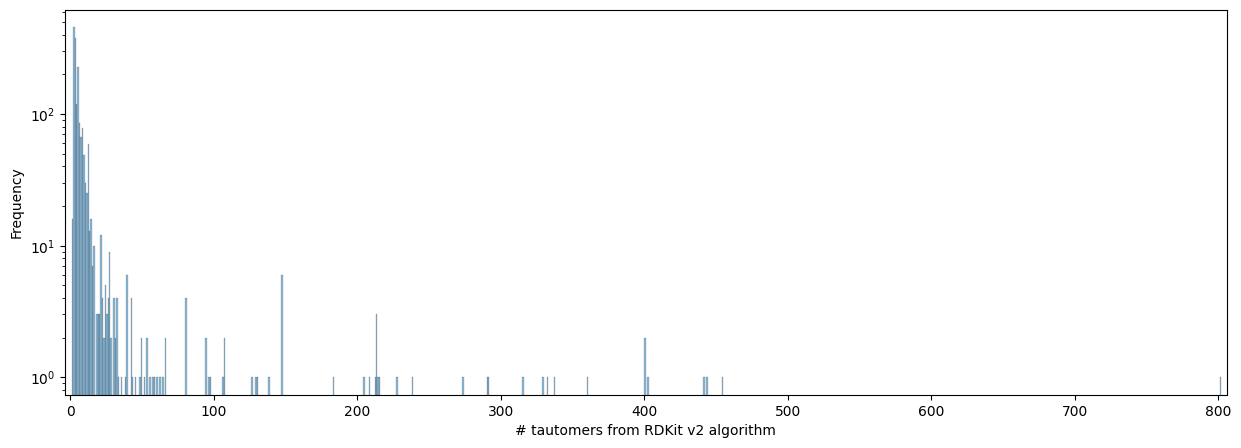

In [60]:
n_tauts_baseline = df_melted_aggregated.select("n_TautomerEnumerator")
x_min_value = n_tauts_baseline.min().item()
x_max_value = n_tauts_baseline.max().item()

x_buffer = 5

x_min = x_min_value - x_buffer
x_max = x_max_value + x_buffer

# Set the histogram bins so there will be a bin (bar) for each integer value
bins = range(x_min, x_max, 1)

# Set the size of the plot
plt.figure(figsize=(15, 5))

# Create the histogram plot
sns.histplot(
    n_tauts_baseline,
    bins=bins,
    legend=False,
    log_scale=(False, True),
    )

plt.ylabel("Frequency")
plt.xlabel("# tautomers from RDKit v2 algorithm")

plt.xlim(x_min, x_max)

plt.show()

Let's also check the distribution of the number of experimentally-observed tautomers.

In [61]:
frequency_table_Expt = df_melted_aggregated.select(pl.col("n_Expt").value_counts()).unnest("n_Expt").sort("n_Expt").with_columns(
    pct = ((pl.col("count") / pl.col("count").sum()) * 100).round(1),
    cumulative_pct = ((pl.col("count").cum_sum() / pl.col("count").sum()) * 100).round(1)
)
frequency_table_Expt

n_Expt,count,pct,cumulative_pct
u32,u32,f64,f64
1,28,1.6,1.6
2,1518,85.5,87.0
3,197,11.1,98.1
4,23,1.3,99.4
5,10,0.6,100.0


So more than 85% of the Refs have two tautomers, and most of the remaining Refs have three.

Now we can check how many Refs have the same set of tautomers as RDKit's default tautomerizer, for each other source that lists SMILES:

In [62]:
df_same = df_melted_aggregated.select(cs.starts_with("same_").exclude("same_TautomerEnumerator_InChI").name.prefix("count_")).sum()
df_same

count_same_GetV1TautomerEnumerator,count_same_NIH,count_same_CACTVS,count_same_Expt
u32,u32,u32,u32
1207,0,0,453


In [63]:
df_same.select((pl.all()/Ref_count * 100).round(1).name.prefix("%")).sum()

%count_same_GetV1TautomerEnumerator,%count_same_NIH,%count_same_CACTVS,%count_same_Expt
f64,f64,f64,f64
68.0,0.0,0.0,25.5


Let's compare the various sources to RDKit's default tautomerizer:
- GetV1TautomerEnumerator: The fact that ~68% of the sets of tautomers are the same comports with Greg Landrum's note that "the code adds a missed case to the enumeration rule set"--adding one rule seems like a minor change.
- NIH and CACTVS: The fact that these sources have no Refs where the set of tautomers are the same is not surprising because we enumerated tautomers for a limited number of Refs for NIH and CACTVS.
- Expt: The fact that ~25.5% of the sets of tautomers are the same seems to reflect that the default tautomerizer didn't find tautomers beyond those observed experimentally. If we filter down to these matching sets, we find that there are only a few tautomers in each case:

In [64]:
df_same_Expt = df_melted_aggregated.filter(pl.col("same_Expt") == True).select(["Ref", "same_Expt", "n_Expt", "n_TautomerEnumerator", "tauts_TautomerEnumerator", "tauts_Expt"]).sort("Ref")
df_same_Expt.head()

Ref,same_Expt,n_Expt,n_TautomerEnumerator,tauts_TautomerEnumerator,tauts_Expt
i64,bool,u32,u32,list[str],list[str]
2,true,2,2,"[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]"
3,true,2,2,"[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]"
24,true,1,1,"[""N=c1cccccc1N""]","[""N=c1cccccc1N""]"
40,true,3,3,"[""O=C1CC(c2ccccc2)=NN1c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]"", ""O=[N+]([O-])c1ccc(-n2nc(-c3ccccc3)cc2O)c([N+](=O)[O-])c1"", ""O=c1cc(-c2ccccc2)[nH]n1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]""]","[""O=[N+]([O-])c1ccc(-n2nc(-c3ccccc3)cc2O)c([N+](=O)[O-])c1"", ""O=c1cc(-c2ccccc2)[nH]n1-c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]"", ""O=C1CC(c2ccccc2)=NN1c1ccc([N+](=O)[O-])cc1[N+](=O)[O-]""]"
41,true,3,3,"[""Cc1cc(=O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])[nH]1"", ""CC1=NN(c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])C(=O)C1"", ""Cc1cc(O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])n1""]","[""Cc1cc(O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])n1"", ""CC1=NN(c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])C(=O)C1"", ""Cc1cc(=O)n(-c2ccc([N+](=O)[O-])cc2[N+](=O)[O-])[nH]1""]"


and the maximum number of experimentally-observed tautomers is three:

In [65]:
df_same_Expt.select(pl.col("n_Expt")).max().item()

3

### Statistical comparison

We define a dictionary of sources and their type:

- baseline (RDKit TautomerEnumerator)
- all: we have data for all Refs
- manual: we gathered data manually, so we do not have data for all Refs

In [66]:
# List sources, and the sources to compare to the first source
sources = {
    "TautomerEnumerator": "baseline",
    "GetV1TautomerEnumerator": "all",
    "NIH": "manual",
    "CACTVS": "manual",
    "Expt": "all",
}
sources_compare = {source:kind for source, kind in sources.items() if kind != "baseline"}

Now we set up data structures to hold data from the dataframe's nDiff_ columns--the difference in the number of tautomers for the baseline source minus for another source.

In [67]:
# For each other source, compare it to RDKit V2

# Create several dictionaries where each key will be a tautomer source
n_tauts_diff = dict()
n_tauts_diff_no_zeros = dict()
n_tauts_diff_positive = dict()
n_tauts_diff_negative = dict()
for source in sources_compare.keys():
    # Extract the data from the dataframe's n_tauts_diff... columns
    nDiff_col = f"nDiff_{source.replace('tauts_', '')}"
    this_n_tauts_diff = df_melted_aggregated.filter(pl.col(nDiff_col).is_not_null())[nDiff_col].to_list()
    # Remove None values to prevent errors
    this_n_tauts_diff_clean = [item for item in this_n_tauts_diff if item is not None]
    n_tauts_diff.update({source: this_n_tauts_diff_clean})
    n_tauts_diff_no_zeros.update({source: [diff for diff in n_tauts_diff[source] if diff != 0]})
    n_tauts_diff_positive.update({source: [diff for diff in n_tauts_diff_no_zeros[source] if (diff is not None) and (diff > 0)]})
    n_tauts_diff_negative.update({source: [diff for diff in n_tauts_diff_no_zeros[source] if (diff is not None) and (diff < 0)]})

Next we define a function to return various descriptive statistics of interest for an iterable, which we'll apply to those lists of the difference in the number of tautomers between sources.

In [68]:
def stats_for_iterable(iterable: Iterable) -> dict[str : int | float]:
    """Calculate descriptive statistics for an iterable.
    The input could be a set, but be aware that a set can only contain each value once.

    :param iterable: Iterable to be analyzed
    :returns: Descriptive statistics including counts of some values, mean, median, mode, and standard deviation
    """
    iterable_clean = [item for item in iterable if item is not None]
    stats = dict()
    for delta in range(-5, 6):
        stats.update({f"count({delta})": iterable_clean.count(delta)})

    try:
        mean = statistics.mean(iterable_clean)
    except StatisticsError:
        mean = None

    try:
        median = statistics.median(iterable_clean)
    except StatisticsError:
        median = None

    try:
        mode = statistics.mode(iterable_clean)
    except StatisticsError:
        mode = None

    stats.update(
        {
            "mean": mean,
            "median": median,
            "mode": mode,
        }
    )
    try:
        stats.update({"std dev": statistics.stdev(iterable_clean)})
    except StatisticsError:
        stats.update({"std dev": -1})
    return stats

To address the original question of which algorithms find more tautomers, we compute the mean.

In [69]:
print(f'{"Source":25} Mean')
for source in sources_compare.keys():
    stats = stats_for_iterable(df_melted_aggregated[f"nDiff_{source.replace('tauts','')}"])
    print(f'{source:25} {stats["mean"]:.2f}')

Source                    Mean
GetV1TautomerEnumerator   -4.66
NIH                       212.00
CACTVS                    55.80
Expt                      9.78


In [70]:
df_comparison = df_melted_aggregated.select(cs.starts_with("nDiff_").name.prefix("count_")).sum()
df_comparison

count_nDiff_GetV1TautomerEnumerator,count_nDiff_NIH,count_nDiff_CACTVS,count_nDiff_TautomerEnumerator_InChI,count_nDiff_Expt
i64,i64,i64,i64,i64
-8269,1908,279,2530,17366


In [71]:
df_comparison.select((pl.all()/Ref_count).round(1).name.prefix("per_ref_")).sum()

per_ref_count_nDiff_GetV1TautomerEnumerator,per_ref_count_nDiff_NIH,per_ref_count_nDiff_CACTVS,per_ref_count_nDiff_TautomerEnumerator_InChI,per_ref_count_nDiff_Expt
f64,f64,f64,f64,f64
-4.7,1.1,0.2,1.4,9.8


These statistics are skewed by selection bias: I chose several Refs with hundreds of tautomers to gather manual data on from NIH and CACTVS, so the difference in the number of tautomers for those Refs can be quite large. Whereas the experimental results are available for all Refs, and in many cases there are only a few tautomers for those Refs, so averaged over all Refs the mean difference in the number of tautomers for the experimental results is relatively small.

Let's make a fairer comparison by narrowing the Refs to the narrowest set, namely for CACTVS--all the other sets (NIH, Expt, and RDKit GetV1TautomerEnumerator) are supersets of that narrow set.

In [72]:
df_narrow_set = df_melted_aggregated.filter(pl.col("nDiff_CACTVS").is_not_null()).select(["Ref", "n_TautomerEnumerator", "n_GetV1TautomerEnumerator", "n_CACTVS", "n_NIH", "n_Expt", "nDiff_GetV1TautomerEnumerator", "nDiff_CACTVS", "nDiff_NIH", "nDiff_Expt"]).sort("Ref")
df_narrow_set

Ref,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_CACTVS,n_NIH,n_Expt,nDiff_GetV1TautomerEnumerator,nDiff_CACTVS,nDiff_NIH,nDiff_Expt
i64,u32,u32,u32,u32,u32,i64,i64,i64,i64
467,360,353,275,32,2,7,85,328,358
890,454,305,258,31,2,149,196,423,452
891,337,340,324,26,2,-3,13,311,335
1512,3,2,16,8,2,1,-13,-5,1
1704,3,2,5,4,2,1,-2,-1,1


In [73]:
n_narrow_set = df_narrow_set.select(pl.len()).item()
n_narrow_set

5

In [74]:
df_melted_aggregated.filter(pl.col("nDiff_CACTVS").is_not_null()).select(["Ref", "n_TautomerEnumerator", "n_GetV1TautomerEnumerator", "n_CACTVS", "n_NIH", "n_Expt", "nDiff_GetV1TautomerEnumerator", "nDiff_CACTVS", "nDiff_NIH", "nDiff_Expt"]).sort("Ref")
df_narrow_set

Ref,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_CACTVS,n_NIH,n_Expt,nDiff_GetV1TautomerEnumerator,nDiff_CACTVS,nDiff_NIH,nDiff_Expt
i64,u32,u32,u32,u32,u32,i64,i64,i64,i64
467,360,353,275,32,2,7,85,328,358
890,454,305,258,31,2,149,196,423,452
891,337,340,324,26,2,-3,13,311,335
1512,3,2,16,8,2,1,-13,-5,1
1704,3,2,5,4,2,1,-2,-1,1


In [75]:
df_narrow_set = df_narrow_set.select(cs.starts_with("nDiff_").name.prefix("sum_")).sum()
df_narrow_set

sum_nDiff_GetV1TautomerEnumerator,sum_nDiff_CACTVS,sum_nDiff_NIH,sum_nDiff_Expt
i64,i64,i64,i64
155,279,1056,1147


In [76]:
df_narrow_set.select((pl.all()/n_narrow_set).round(1).name.prefix("per_ref_"))

per_ref_sum_nDiff_GetV1TautomerEnumerator,per_ref_sum_nDiff_CACTVS,per_ref_sum_nDiff_NIH,per_ref_sum_nDiff_Expt
f64,f64,f64,f64
31.0,55.8,211.2,229.4


So in this fairer comparison, the sources' differences in number of tautomers identified compared to RDKit's baseline algorithm are, from least to greatest deficit:
- RDKit's GetV1TautomerEnumerator, which finds 31.0 fewer tautomers per reference
- CACTVS algorithm, which finds 55.8 fewer tautomers per reference
- NIH algorithm, which finds 211.2 fewer tautomers per reference
- Experimental results, which finds 229.4 fewer tautomers per reference

In [77]:
max(df_melted_aggregated["nDiff_GetV1TautomerEnumerator"])

149

In [78]:
min(df_melted_aggregated["nDiff_GetV1TautomerEnumerator"])

-418

In [79]:
stats_for_iterable(df_melted_aggregated["nDiff_GetV1TautomerEnumerator"])

{'count(-5)': 19,
 'count(-4)': 33,
 'count(-3)': 47,
 'count(-2)': 65,
 'count(-1)': 96,
 'count(0)': 1208,
 'count(1)': 85,
 'count(2)': 7,
 'count(3)': 13,
 'count(4)': 15,
 'count(5)': 2,
 'mean': -4.655968468468468,
 'median': 0.0,
 'mode': 0,
 'std dev': 26.426286494292796}

In [80]:
stats_for_iterable(df_melted_aggregated["nDiff_TautomerEnumerator_InChI"])

{'count(-5)': 0,
 'count(-4)': 0,
 'count(-3)': 0,
 'count(-2)': 0,
 'count(-1)': 0,
 'count(0)': 1292,
 'count(1)': 162,
 'count(2)': 110,
 'count(3)': 56,
 'count(4)': 36,
 'count(5)': 27,
 'mean': 1.4245495495495495,
 'median': 0.0,
 'mode': 0,
 'std dev': 11.796726441117364}

### Graphical comparison

We plot a histogram of the difference in the number of tautomers for the two sources which have data for all Refs: RDKit V1 enumerator, and experimental. We'll save the sparse-data sources for another plot for clarity.

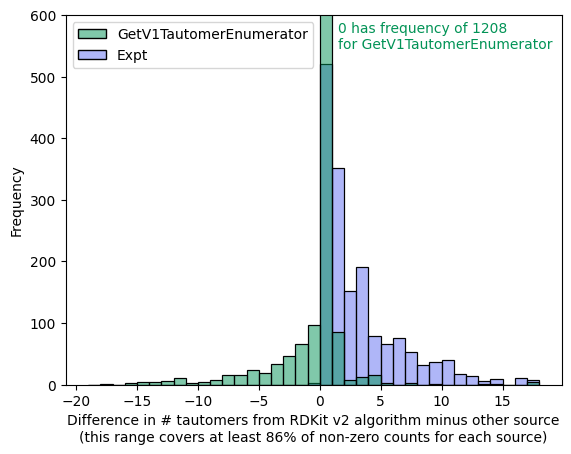

In [81]:
n_tauts_diff_all = {source: n_tauts_diff[f"{source}"] for source in sources.keys() if sources[source] == "all"}

# Set the x bounds (will go from negative to positive of this value)
x_len = 17

# Calculate the percent of each data series (excluding delta=0) this plot covers

# Create dictionaries to store values in; keys will be data sources
n_tauts_diff_no_zeros_this_range = dict()
non_zero_counts_this_range = dict()
for source in n_tauts_diff_all.keys():
    n_tauts_diff_no_zeros_this_range.update(
        {source: [diff for diff in n_tauts_diff_no_zeros[source] if abs(diff) <= x_len]}
    )
    non_zero_counts_this_range.update(
        {
            source: len(n_tauts_diff_no_zeros_this_range[source])
            / len(n_tauts_diff_no_zeros[source])
        }
    )
non_zero_counts_this_range_min = min(list(non_zero_counts_this_range.values()))

# Set an accessible color palette from https://venngage.com/tools/accessible-color-palette-generator
colors = [
    "#029356",
    # "#009eb0",
    # "#0073e6",
    "#606ff3",
    # "#9b8bf4",
    ]
sns.set_palette(sns.color_palette(colors))

plt.ylabel("Frequency")
xlabel = "Difference in # tautomers from RDKit v2 algorithm minus other source"
xlabel += f"\n(this range covers at least {non_zero_counts_this_range_min:.0%} of non-zero counts for each source)"
plt.xlabel(xlabel)

# Limit the max y to avoid making smaller y values too hard to discern
plt.ylim(0, 600)

# Because this max y cuts off the y value for GetV1TautomerEnumerator at delta = 0, show the value as a label

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff["GetV1TautomerEnumerator"].count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0 for GetV1TautomerEnumerator
plt.text(
    1.5,
    max(plt.ylim()) * 0.9,
    f"0 has frequency of {frequency_at_zero}\nfor GetV1TautomerEnumerator",
    ha="left",
    va="bottom",
    color=colors[0],
)

# Set the histogram bins so there will be a bin (bar) for each integer value
x_min = (-1 * x_len) - 2
x_max = x_len + 2
bins = range(x_min, x_max, 1)

# Create the histogram plot
sns.histplot(n_tauts_diff_all, bins=bins)

plt.show()

Here's the histogram for the RDKit V1 enumerator only.

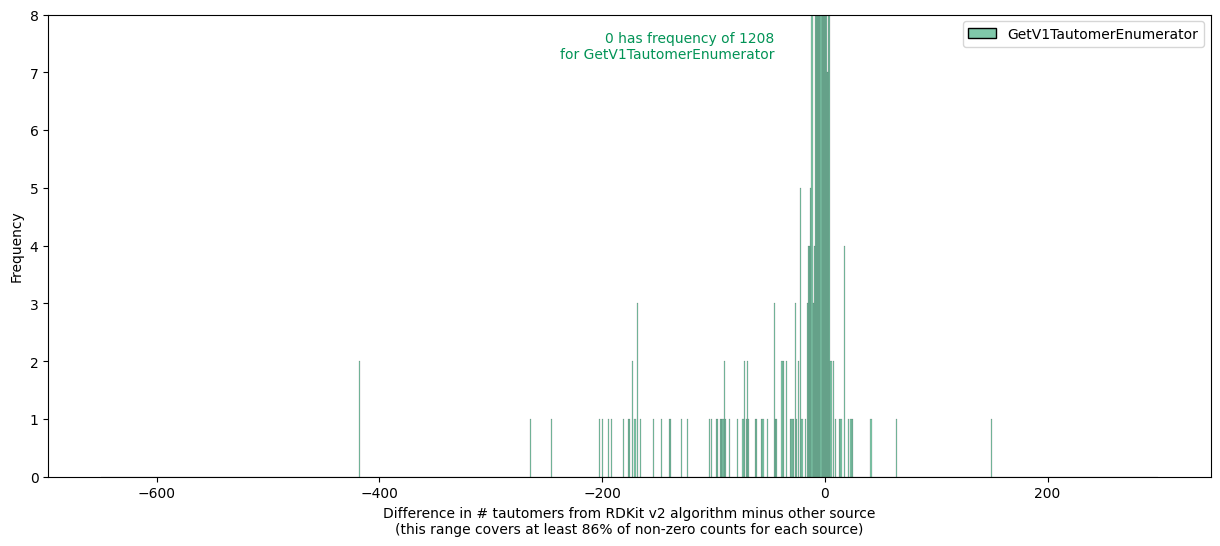

In [82]:
n_tauts_diff_all = {source: n_tauts_diff[f"{source}"] for source in sources.keys() if source == "GetV1TautomerEnumerator"}

# Set the x bounds (will go from negative to positive of this value)
x_axis_min = -650
x_axis_max = 300

# Set the histogram bins so there will be a bin (bar) for each integer value
bins = range(x_axis_min, x_axis_max, 1)

# Calculate the percent of each data series (excluding delta=0) this plot covers

# Create dictionaries to store values in; keys will be data sources
n_tauts_diff_no_zeros_this_range = dict()
non_zero_counts_this_range = dict()
for source in n_tauts_diff_all.keys():
    n_tauts_diff_no_zeros_this_range.update(
        {source: [diff for diff in n_tauts_diff_no_zeros[source] if abs(diff) <= x_len]}
    )
    non_zero_counts_this_range.update(
        {
            source: len(n_tauts_diff_no_zeros_this_range[source])
            / len(n_tauts_diff_no_zeros[source])
        }
    )
non_zero_counts_this_range_min = min(list(non_zero_counts_this_range.values()))

# Set an accessible color palette from https://venngage.com/tools/accessible-color-palette-generator
colors = [
    "#029356",
    # "#009eb0",
    # "#0073e6",
    "#606ff3",
    # "#9b8bf4",
    ]
sns.set_palette(sns.color_palette(colors))

# Set the width and height of the plot
plt.figure(figsize=(15, 6))  # Adjust the width as per your requirement

# Create the histogram plot
sns.histplot(n_tauts_diff_all, bins=bins)

plt.ylabel("Frequency")
xlabel = "Difference in # tautomers from RDKit v2 algorithm minus other source"
xlabel += f"\n(this range covers at least {non_zero_counts_this_range_min:.0%} of non-zero counts for each source)"
plt.xlabel(xlabel)

# Limit the max y to avoid making smaller y values too hard to discern
plt.ylim(0, 8)

# Because this max y cuts off the y value for GetV1TautomerEnumerator at delta = 0, show the value as a label

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff["GetV1TautomerEnumerator"].count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0 for GetV1TautomerEnumerator
plt.text(
    -45,
    max(plt.ylim()) * 0.9,
    f"0 has frequency of {frequency_at_zero}\nfor GetV1TautomerEnumerator",
    ha="right",
    va="bottom",
    color=colors[0],
)

plt.show()

Here's the histogram for sources with sparse data: NIH and CACTVS.

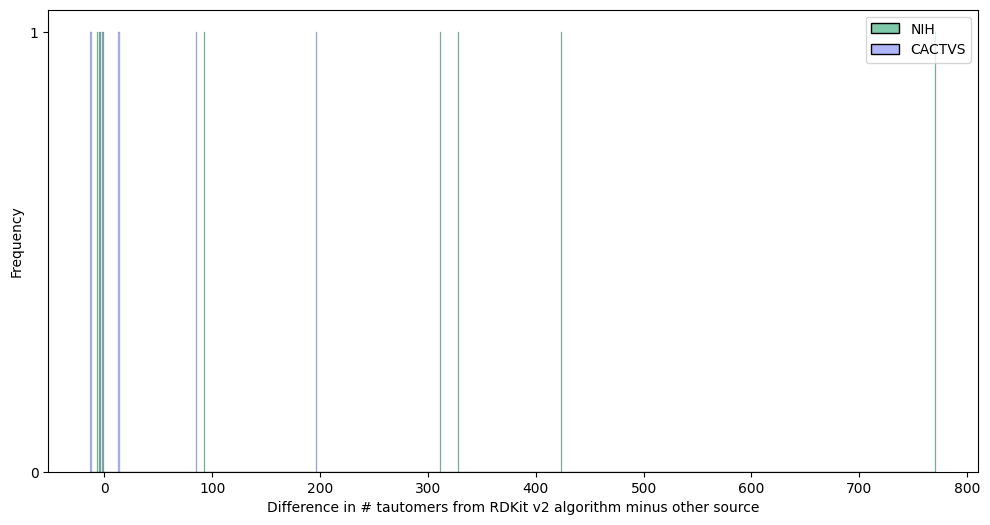

In [83]:
# Plot histogram of n_tauts_diff for sources which do not have data for all refs, because each molecule is run manually
n_tauts_diff_manual = {source: n_tauts_diff[source] for source in sources.keys() if sources[source] == "manual"}

#TODO instead of using .to_list and then min() and max(), use Polars expressions to get min and max

# Set the histogram bins so there will be a bin (bar) for each integer value
combined_set = set(item for sublist in n_tauts_diff_manual.values() for item in sublist)
x_min, x_max = min(combined_set), max(combined_set)

bins = range(x_min, x_max+1, 1)

colors = [
    # "#029356",
    "#009eb0",
    # "#0073e6",
    # "#606ff3",
    "#9b8bf4",
    ]

plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
sns.histplot(
    n_tauts_diff_manual, 
    bins=bins,
    )
sns.set_palette(sns.color_palette(colors))

# Set the x bounds (will go from negative to positive of this value)

plt.ylabel("Frequency")
xlabel = f"Difference in # tautomers from RDKit v2 algorithm minus other source"
plt.xlabel(xlabel)

# Get the current axis from the plot
ax = plt.gca()

# Set y-axis ticks to be at only integer values
ax.yaxis.set_major_locator(MultipleLocator(1))

plt.show()

### InChI coverage of multiple SMILES

Similar to what we did with the experimentally-observed structures, let's check how well InChI represents multiple SMILES with one InChI. We start by checking how many fewer InChI are required to represent the set of SMILES for each Ref.

In [84]:
df_InChI = df_melted_aggregated.select(pl.col("nDiff_TautomerEnumerator_InChI").value_counts()).unnest("nDiff_TautomerEnumerator_InChI").sort("nDiff_TautomerEnumerator_InChI").with_columns(
    pct = ((pl.col("count") / pl.col("count").sum()) * 100).round(1),
    cumulative_pct = ((pl.col("count").cum_sum() / pl.col("count").sum()) * 100).round(1),
)
df_InChI.head(10)

nDiff_TautomerEnumerator_InChI,count,pct,cumulative_pct
i64,u32,f64,f64
0,1292,72.7,72.7
1,162,9.1,81.9
2,110,6.2,88.1
3,56,3.2,91.2
4,36,2.0,93.2
5,27,1.5,94.8
6,24,1.4,96.1
7,18,1.0,97.1
8,6,0.3,97.5


For almost 73% of the Refs, InChI does not need any fewer representations than SMILES; that is, one InChI is not covering multiple SMILES. For about 9% of Refs, InChI needs one fewer representation that SMILES. Here's how many total representations each uses:

In [85]:
df_InChI_compare = df_melted_aggregated.select(["n_TautomerEnumerator", "n_TautomerEnumerator_InChI", "nDiff_TautomerEnumerator_InChI"]).select(pl.all().name.prefix("sum_")).sum()
df_InChI_compare

sum_n_TautomerEnumerator,sum_n_TautomerEnumerator_InChI,sum_nDiff_TautomerEnumerator_InChI
u32,u32,i64
21163,18633,2530


and on a per-reference basis:

In [86]:
df_InChI_compare.select((pl.all()/Ref_count).round(1).name.prefix("per_ref_"))

per_ref_sum_n_TautomerEnumerator,per_ref_sum_n_TautomerEnumerator_InChI,per_ref_sum_nDiff_TautomerEnumerator_InChI
f64,f64,f64
11.9,10.5,1.4


and on a percent basis:

In [87]:
nDiff_EnumeratorInChI = df_InChI_compare["sum_nDiff_TautomerEnumerator_InChI"].item()
n_Enumerator = df_InChI_compare["sum_n_TautomerEnumerator"].item()
delta = (nDiff_EnumeratorInChI / n_Enumerator)
print(f"{nDiff_EnumeratorInChI} / {n_Enumerator} = {delta:.0%}")

2530 / 21163 = 12%


So InChI needs on average 10.5 representations per reference, a reduction of 1.4 (12%) from SMILES. If InChI were totally successful at representing all tautomers with one InChI, it would need only one InChI per reference, so clearly there are improvements to be made to reach that goal.

Let's break that out the reduction of the number of representations using InChI into a histogram.

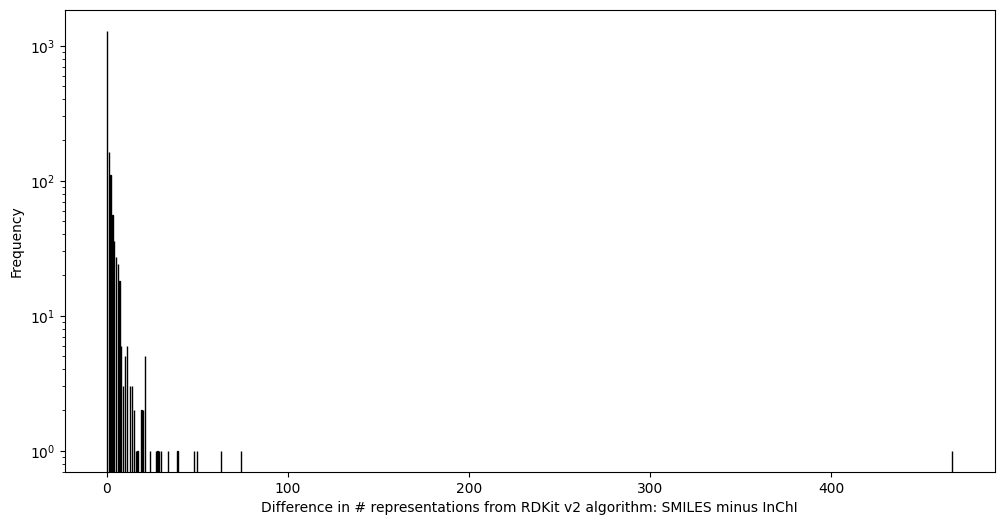

In [88]:
# Plot histogram of n_tauts_diff for InChI compared to SMILES for RDKit V2
n_tauts_diff_InChI = df_melted_aggregated["nDiff_TautomerEnumerator_InChI"].to_list()

n_tauts_diff_InChI_large = [item for item in n_tauts_diff_InChI if item > 100]

x_min, x_max = min(n_tauts_diff_InChI), max(n_tauts_diff_InChI)

plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
sns.histplot(
    df_melted_aggregated["nDiff_TautomerEnumerator_InChI"], 
    log_scale=(False, True),
    linewidth=1,
    )

# Set the x bounds (will go from negative to positive of this value)

plt.ylabel("Frequency")
xlabel = f"Difference in # representations from RDKit v2 algorithm: SMILES minus InChI"
plt.xlabel(xlabel)

plt.show()

## Visualizing tautomeric structures

Let's make these results more concrete by visualizing molecular structures. To set up a grid with each row representing a tautomer source, we'll use my RDKit contribution MolsMatrixToGridImage() so we don't have to worry about how many tautomers each source has.

The columns will also have meaning: To demonstrate which sources have the same structures, we'll have each column represent a structure. If that source has that structure, there will be an entry in that cell; if not, it will be blank. To set that up, we define a function to align one iterable below another.

In [89]:
def align_ordered_iterables(
        ordered_iterable1: list|tuple,
        ordered_iterable2: list|tuple,
        filler = "",
) -> Iterable:
    """Align the second ordered iterable under the first (in columns), using the filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  c,  b
    list2: a,  f,  c,  e,  d

    output:
    list2: a,  c, "",  f,  e,  d

    Note that no other ordering is applied to either input iterable, 
    and items in the second which are not in the first will be kept in their input order.
    If you want them to be ordered in some way, for example alphabetically, order them before calling this function.

    :param list1: Template list
    :param list2: List to be aligned under the template list
    :param filler: The filler entry to use to provide an "empty" column to align list2 under list1; default is empty string but can be a number or anything else
    :returns: Aligned list2 such that its entries will line up under the same values in list1, or be placed to the right if they are not in list1
    """
    # If either list has no elements, return the initial ordered_iterable2
    if any([len(ordered_iterable1)==0, len(ordered_iterable2)==0]):
        return ordered_iterable2   
    
    # Determine index for each element in ordered_iterable2:
    ordered_iterable2_indices = []
    ordered_iterable2_index_max = len(ordered_iterable1) - 1
    for ordered_iterable2_item in ordered_iterable2:
        try:
            ordered_iterable2_index = ordered_iterable1.index(ordered_iterable2_item)
        # If item from input 2 isn't in input 1, append item to the (growing) index list
        except ValueError:
            ordered_iterable2_index_max += 1
            ordered_iterable2_index = ordered_iterable2_index_max
        # If get an AttributeError, tell user that have a bad data type
        except AttributeError:
            raise AttributeError(f"The first iterable input must be a list or tuple, not a set or dictionary; it is {ordered_iterable1}, which is a {type(ordered_iterable1).__name__}")
        ordered_iterable2_indices.append(ordered_iterable2_index)

    # Create "empty" (all filler) ordered_iterable2 aligned--may be longer than ordered_iterable2 due to blank spaces
    ordered_iterable2_aligned = [filler] * (max(ordered_iterable2_indices) + 1)

    # Slot in items from ordered_iterable2 to overwrite filler entries
    for i, ordered_iterable2_col in enumerate(ordered_iterable2_indices):
        try:
            ordered_iterable2_aligned[ordered_iterable2_col] = ordered_iterable2[i]
        except (TypeError, KeyError):
                raise TypeError(f"The second iterable input must be a list or tuple, not a set or dictionary; it is {ordered_iterable2}, which is a {type(ordered_iterable2).__name__}")

    return ordered_iterable2_aligned

In [90]:
# Output SMILES for all RDKit V2 tautomers for a ref
# tauts_890_rdkitv2 = df_melted_aggregated_example[0]["flat_tautsTautomerEnumerator"].item().to_list()
# import csv

# filename = "../data/ref890_rdkit_v2_tautomers.csv"

# # Open the file in write mode
# with open(filename, 'w', newline='') as csvfile:
#     # Create a CSV writer object
#     csvwriter = csv.writer(csvfile)

#     # Write each item of the list on its own line
#     csvwriter.writerows([[item] for item in tauts_890_rdkitv2])


In [91]:
df_melted_aggregated_example = df_melted_aggregated.filter(pl.col("Ref") == 1512) # Asked Marc Nicklaus to generate CACTVS tautomers for
df_melted_aggregated_example

Ref,canon_sml,tauts_TautomerEnumerator,tauts_GetV1TautomerEnumerator,tauts_NIH,tauts_CACTVS,tauts_TautomerEnumerator_InChI,tauts_Expt,n_TautomerEnumerator,n_GetV1TautomerEnumerator,n_NIH,n_CACTVS,n_TautomerEnumerator_InChI,n_Expt,same_GetV1TautomerEnumerator,nDiff_GetV1TautomerEnumerator,same_NIH,nDiff_NIH,same_CACTVS,nDiff_CACTVS,same_TautomerEnumerator_InChI,nDiff_TautomerEnumerator_InChI,same_Expt,nDiff_Expt
i64,list[str],list[str],list[str],list[str],list[str],list[str],list[str],u32,u32,u32,u32,u32,u32,bool,i64,bool,i64,bool,i64,bool,i64,bool,i64
1512,"[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP(CC)(=NC1=CC(C(c2ccccc2)(c2ccccc2)c2ccccc2)=CC(C(C)(C)C)C1=O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1""]","[""CCP1(CC)(c2ccccc2)N=C2CC(C(c3ccccc3)(c3ccccc3)c3ccccc3)=CC(C(C)(C)C)=C2O1"", ""CCP(CC)(=NC1=CC(C(c2ccccc2)(c2ccccc2)c2ccccc2)=CC(C(C)(C)C)C1=O)c1ccccc1"", … ""CCP1(CC)(c2ccccc2)N=C2C=C(C(c3ccccc3)(c3ccccc3)c3ccccc3)C=C(C(C)(C)C)C2O1""]","[""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", ""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", … ""CC[P](CC)(=NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5""]","[""InChI=1S/C39H42NOP/c1-6-42(7-2,34-26-18-11-19-27-34)40-36-29-33(28-35(37(36)41)38(3,4)5)39(30-20-12-8-13-21-30,31-22-14-9-15-23-31)32-24-16-10-17-25-32/h8-29,35H,6-7H2,1-5H3"", ""InChI=1S/C39H42NOP/c1-6-42(7-2,34-26-18-11-19-27-34)40-36-29-33(28-35(37(36)41)38(3,4)5)39(30-20-12-8-13-21-30,31-22-14-9-15-23-31)32-24-16-10-17-25-32/h8-29,41H,6-7H2,1-5H3"", ""InChI=1S/C39H42NOP/c1-6-42(7-2,34-26-18-11-19-27-34)40-36-29-33(28-35(37(36)41-42)38(3,4)5)39(30-20-12-8-13-21-30,31-22-14-9-15-23-31)32-24-16-10-17-25-32/h8-29,40H,6-7H2,1-5H3""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1""]",3,2,8,16,3,2,false,1,false,-5,false,-13,false,0,false,1


In [92]:
df_melted_aggregated_example = df_melted_aggregated.filter(pl.col("Ref") == 467)
# df_melted_aggregated_example = df_melted_aggregated.filter(pl.col("Ref") == 890) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_example = df_melted_aggregated.filter(pl.col("Ref") == 891) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_example = df_melted_aggregated.filter(pl.col("Ref") == 1512) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_example = df_melted_aggregated.filter(pl.col("Ref") == 1704) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_example

In [93]:
# df_melted_aggregated_300 = df_melted_aggregated.filter(pl.col("n_TautomerEnumerator") > 300)
df_melted_aggregated_300 = df_melted_aggregated.filter(pl.col("n_TautomerEnumerator") > 300)

smls_v2_300 = [item[0] for item in df_melted_aggregated_300["tauts_TautomerEnumerator"].to_list()]
# df_melted_aggregated_example["flat_tautsTautomerEnumerator"].to_list()

In [94]:
# For the various data sources, extract SMILES, align them sequentially, and create RDKit molecules for drawing 
smls_expt = df_melted_aggregated_example.select("tauts_Expt").item().to_list()
smls_v2 = df_melted_aggregated_example.select("tauts_TautomerEnumerator").item().to_list()
smls_v2_aligned = align_ordered_iterables(smls_expt, smls_v2)
smls_v1 = df_melted_aggregated_example.select("tauts_GetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_ordered_iterables(smls_v2_aligned, smls_v1)
smls_nih = df_melted_aggregated_example.select("tauts_NIH").item().to_list()
smls_nih_aligned = align_ordered_iterables(smls_v1_aligned, smls_nih)
smls_cactvs = df_melted_aggregated_example.select("tauts_CACTVS").item().to_list()
smls_cactvs_aligned = align_ordered_iterables(smls_nih_aligned, smls_cactvs)

tauts_expt = [mol_from_sml(sml) for sml in smls_expt]
tauts_v2_aligned = [mol_from_sml(sml) if sml else None for sml in smls_v2_aligned]
tauts_v1_aligned = [mol_from_sml(sml) if sml else None for sml in smls_v1_aligned]
tauts_nih_aligned = [mol_from_sml(sml) if sml else None for sml in smls_nih_aligned]
tauts_cactvs_aligned = [mol_from_sml(sml) if sml else None for sml in smls_cactvs_aligned]

In [95]:
def find_first_non_none_index(lst):
    for i, item in enumerate(lst):
        if item is not None:
            return i
    return None  # Return None if all elements are None

Any time we show tautomeric structures, it's helpful to align maximum common substructure (MCS) so we can focus on the differences between the tautomers in the same orientation.

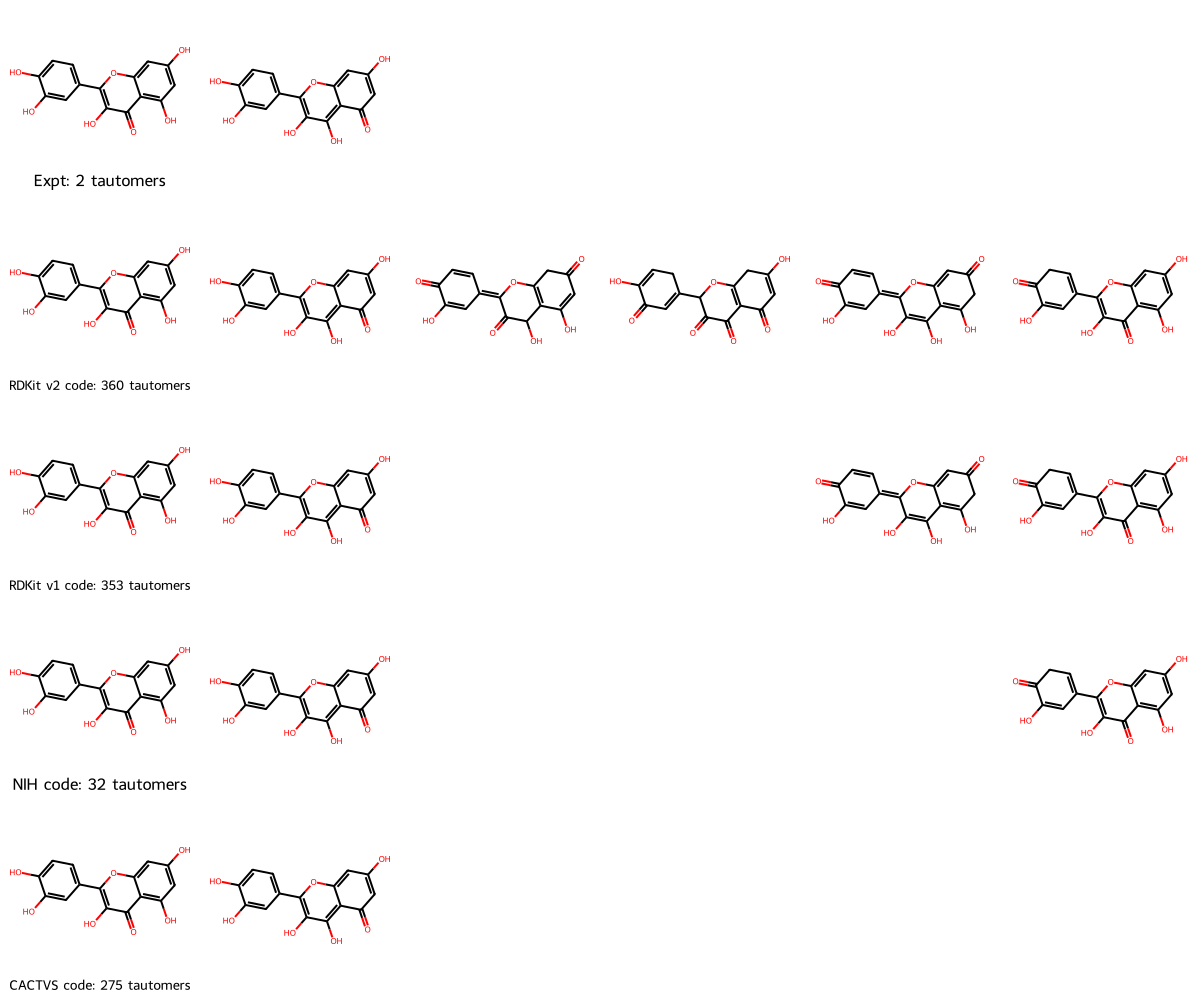

In [96]:
# Plot all sets of tautomers

# Limit number of columns so structures will be readable
max_cols = 6
# Create nested (2D) data structures for Draw.MolsMatrixToGridImage
smls_matrix = [
    smls_expt,
    smls_v2_aligned,
    smls_v1_aligned,
]
tauts_matrix = [
    tauts_expt[:max_cols],
    tauts_v2_aligned[:max_cols],
    tauts_v1_aligned[:max_cols],
]

row_labels = [
    f"Expt: {len(smls_expt)} tautomers",
    f"RDKit v2 code: {len(smls_v2)} tautomers",
    f"RDKit v1 code: {len(smls_v1)} tautomers",
]

# If NIH tautomers generated, add row for them
if not all([sml is None for sml in smls_nih]):
    smls_matrix.append(smls_nih_aligned)
    tauts_matrix.append(tauts_nih_aligned[:max_cols])
    row_labels.append(f"NIH code: {len(smls_nih)} tautomers")

# If CACTVS tautomers generated, add row for them
if not all([sml is None for sml in smls_cactvs]):
    smls_matrix.append(smls_cactvs)
    tauts_matrix.append(tauts_cactvs_aligned[:max_cols])
    row_labels.append(f"CACTVS code: {len(smls_cactvs)} tautomers")

# Initialize a legends matrix with empty strings
legends_matrix = [["" for item in row] for row in tauts_matrix]

# Label first non-empty column in each row with source and number of tautomers
# First row is the template that other rows align under, so first molecule will be non-empty
legends_matrix[0][0] = row_labels[0]
# For subsequent rows, any molecule could be empty (if it's not in the row(s) above)
for label_index, row_label in enumerate(row_labels[1:]):
    col_to_label = find_first_non_none_index(tauts_matrix[label_index+1])

    if col_to_label != None:
        legends_matrix[label_index+1][col_to_label] = row_label

# Align 2D structures based on maximum common substructure (mcs)
# Exclude blank entries to avoid problem with aligning empty molecules
tauts_all = [
    item for sublist in tauts_matrix for item in sublist if item is not None
]
mcs = rdFMCS.FindMCS(
    tauts_all,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_all:
    Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

Draw.MolsMatrixToGridImage(
    molsMatrix=tauts_matrix, legendsMatrix=legends_matrix, useSVG=True, maxMols=1700
)

The important option to set when determining the MCS for tautomers is to allow matching of any bond type, for example a single bond in one structure should match a double bond in another, because tautomers often have different bond orders at the same position. In the RDKit, that option is `bondCompare=rdFMCS.BondCompare.CompareAny`. Notice how extensive the MCS is with that option:

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  warnings.warn(


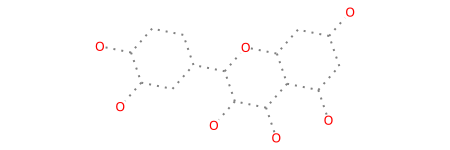

In [97]:
tauts_v2 = [Chem.MolFromSmiles(sml) for sml in smls_v2_aligned]

mcs = rdFMCS.FindMCS(
    tauts_v2,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)

# If there is a maximum common substructure
if mcs_mol:
    # And it has atoms
    if mcs_mol.GetNumAtoms() > 0:
        # Compute the coordinates and align the structures
        Chem.Compute2DCoords(mcs_mol)
        for m in tauts_v2:
            Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)
            
        Draw.MolsToGridImage(tauts_v2, maxMols=100, molsPerRow=7)

mcs_mol

and how much smaller the MCS is if don't use that option:

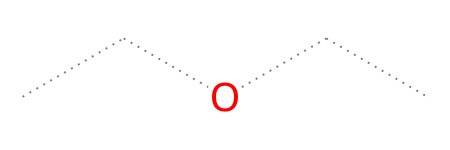

In [98]:
mcs_strict = rdFMCS.FindMCS(
    tauts_v2,
)
mcs_smarts_strict = mcs_strict.smartsString
mcs_mol_strict = Chem.MolFromSmarts(mcs_smarts_strict)
mcs_mol_strict

and thus ineffective at aligning the structures between columns:

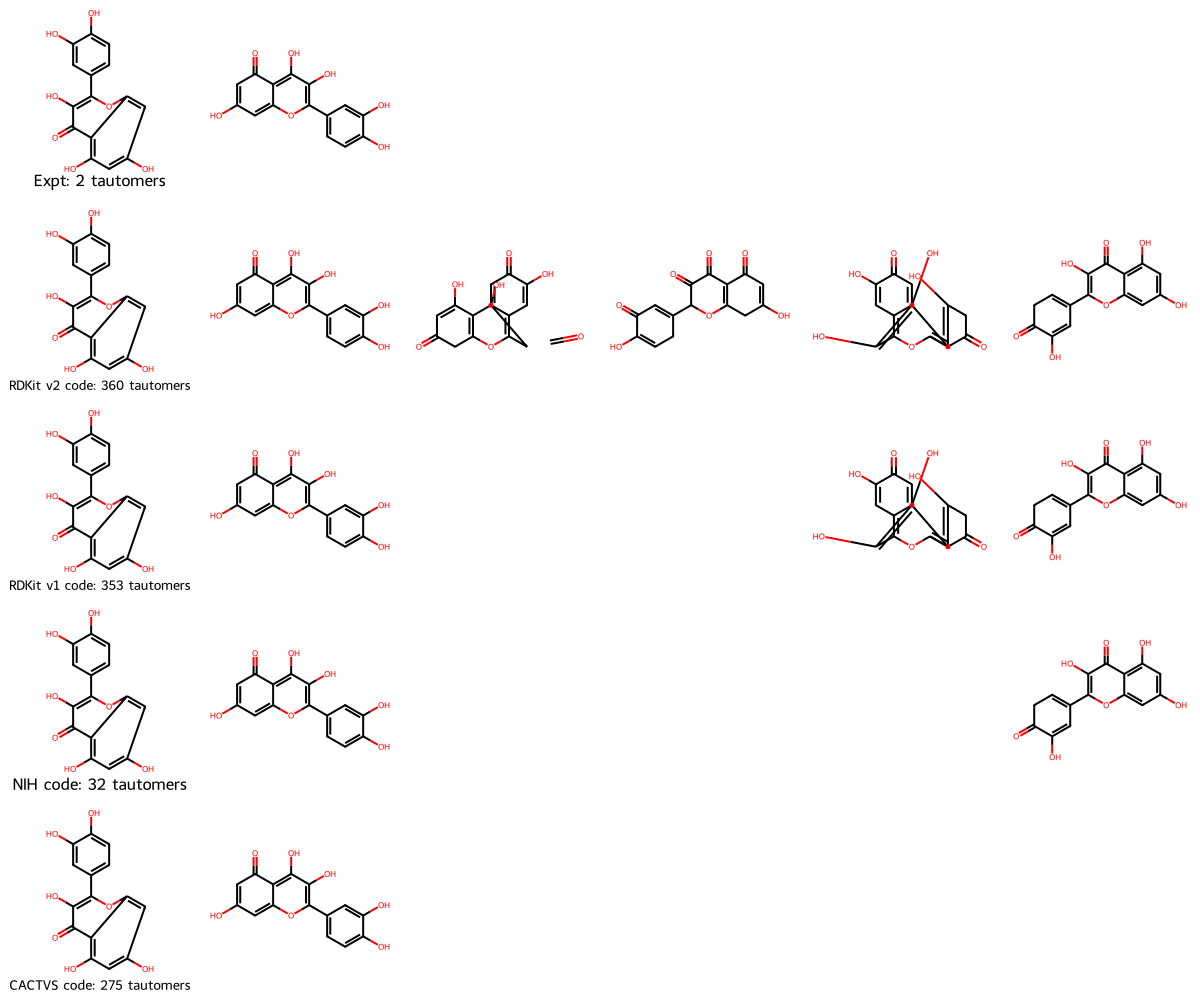

In [99]:
Chem.Compute2DCoords(mcs_mol_strict)
for m in tauts_all:
    Chem.GenerateDepictionMatching2DStructure(m, mcs_mol_strict)

Draw.MolsMatrixToGridImage(
    molsMatrix=tauts_matrix, legendsMatrix=legends_matrix, useSVG=True, maxMols=1700
)

## Conclusions

### Tautomer enumeration algorithms

Comparing the various tautomer sources, let's go from most to fewest number of tautomers found:

- *RDKit's GetV1TautomerEnumerator produces the most, about 5 more per Ref than RDKit's updated algorithm
- *RDKit's updated algorithm is our baseline
- +CACTVS's algorithm finds about 56 fewer tautomers per Ref
- +NIH's algorithm finds about 211 fewer tautomers per Ref
- *Experimental results find about 229 fewer tautomers per Ref

*Comparison of all Refs because data source includes all refs

+Comparison of 5 Refs because data source does not include all refs because it had to be run manually for each Ref

Of course, finding more tautomers is not necessarily better. If a tautomer is not observed experimentally, it may not exist in situ and thus not participate in whatever chemistry the system undergoes. The hundreds of tautomers generated by algorithms may be energetically unfavorable and thus unlikely to exist in situ, though a tautomer that an algorithm misses may be observed experimentally.

The [RDKit 2022.03 release notes](https://www.rdkit.org/docs/BackwardsIncompatibleChanges.html#tautomer-enumeration-improvements) suggest that the updated algorithm deliberately does not produce certain tautomers (which do not match the more-specific rules). Considering [Greg Landrum's comment](https://github.com/rdkit/rdkit/discussions/6997#discussioncomment-7893160) that the "code change adds a missed case to the enumeration rule set", it seems that the number of additional tautomers found by the additional rule is outweighed by the narrowing of rules.

It is interesting that the CACTVS algorithm, which has additional transforms, produces fewer tautomers; though that's for a narrow set of Refs, so it may not hold for a larger dataset. It makes sense that the NIH site produces fewer tautomers than CACTVS because the NIH algorithm is similar and has fewer rules.

### InChI's ability to encompass multiple tautomers with one InChI

Regarding InChI's goal of being ["tautomer-invariant"](https://cactus.nci.nih.gov/presentations/NIHInChI_2021-03/Day_1_Nicklaus_Tautomerism_2021-03-21A.pdf), meaning tautomers of a structure should be assigned the same InChI so a single InChI should suffice to represent all tautomers of a given structure:

- For the experimentally-observed tautomeric structures, InChI needed on average 1.95 identifiers to cover the 1776 Refs, which is much greater than the goal of 1.0 and only 11% better than SMILES (averaging 2.2 identifiers per Ref).
- For the tautomeric structures generated by the updated RDKit algorithm, InChI needs on average 10.5 representations per Ref, a reduction of 1.4 from SMILES, or 12%. It seems encouraging for the generality of InChI that it does as well covering multiple SMILES for algorithmically-generated tautomers, which could be far afield of structures observed experimentally.

So overall the current InChI implementation has modest success in covering all tautomers of a structure with one InChI. Nicklaus and others are working "[Toward a Comprehensive Treatment of Tautomerism in Chemoinformatics Including in InChI V2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8459712/)" so hopefully that will improve InChI's success.

## Acknowledgments

Many thanks to Marc Nicklaus for running CACTVS tautomer enumerations, giving background on the web tool, and informative discussions. Also thanks to my co-workers at Aionics for discussions about tautomers (this post was done on my own and does not necessarily represent my employer's views).